# Telecom Churn Prediction
The solution code is divided into the following sections: 
* Data understanding
* Preprocessing
* EDA
* Handle missing values
* Feature Engineering
* Model 1 - Customer Churn Prediction
    * Feature Selection and Dimensionality Reduction using PCA
    * Handling Class Imbalance using ADASYN
    * Baseline Model building
    * Cross validation
    * Hyperparameter tuning 
    * Model Evaluation
    * Model Selection
* Model 2 - Identifying Strong Predictors of churn (Important features)
    * Feature Selection using ExtraTreesClassifier
    * Handling Class Imbalance using ADASYN
    * Model building
    * Hyperparameter tuning with Cross Validation
    * Model Evaluation
    
* Strategy recommendation to manage customer churn

# Load libraries

* Loading the required libraries. 
* Initialising the RANDOM_STATE as global constant  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42



Bad key "text.kerning_factor" on line 4 in
C:\Users\Sanjan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Data Understanding

* Load the dataset(telecom_churn_data.csv) file from the data folder. 

In [2]:
data = pd.read_csv(r'../Datasets/telecom_churn_data.csv')
data.head().T

,0,1,2,3,4
mobile_number,7000842753,7001865778,7001625959,7001204172,7000142493
circle_id,109,109,109,109,109
loc_og_t2o_mou,0.0,0.0,0.0,0.0,0.0
std_og_t2o_mou,0.0,0.0,0.0,0.0,0.0
loc_ic_t2o_mou,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
aon,968,1006,1103,2491,1526
aug_vbc_3g,30.4,0.0,0.0,0.0,0.0
jul_vbc_3g,0.0,0.0,0.0,0.0,0.0
jun_vbc_3g,101.2,0.0,4.17,0.0,0.0


We can start to see some useful patterns in the dataset.

* mobile_number is the unique_id column for each customer.
* columns are segregated by months of jun(6), jul(7), aug(8), sep(9) for the year 2014.

Let's check for the count of rows and columns in the given dataset

In [3]:
data.shape

(99999, 226)

It has 99999 customer records and 226 columns in it.

Now we will see the types of the columns in the dataset.

In [4]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

It has 214 numeric and 12 non-numeric columns in the dataset

# Data Preprocessing

#### Helper functions for the data preprocessing

In [5]:
'''
Method Name : separate_columns_month_wise
Input(s)    : 1 DataFrame
Output(s)   : 6 lists  
Description :
- This method reads the columns in the given dataframe and splits them into various categories such as months, date related cols 
  and other common cols  
- Then returns the column lists as output for each of these categories. 
'''
def separate_columns_month_wise(df):

    col_len = len(df.columns)

    jun_cols = []
    jul_cols = []
    aug_cols = []
    sep_cols = []
    common_cols = []
    date_cols = []
    
    for i in range(0, col_len):
        if any(pd.Series(df.columns[i]).str.contains('_6|jun')):
            jun_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_7|jul')):
            jul_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_8|aug')):
            aug_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_9|sep')):
            sep_cols.append(df.columns[i])
        else:
            common_cols.append(df.columns[i])
        
        if any(pd.Series(df.columns[i]).str.contains('date')):
            date_cols.append(df.columns[i])
            
    return jun_cols,jul_cols,aug_cols,sep_cols,common_cols,date_cols

In [6]:
'''
Method Name : separate_column_category_wise
Input(s)    : 1 list
Output(s)   : 4 lists  
Description :
- This method gets the columns list as input and splits them into various sub-categories such as call_usage, recharge columns, 
  incoming and outgoing related cols  
- Then returns the column lists as output for each of these sub-categories. 
'''
def separate_column_category_wise(col_list):
    call_usage_cols = []
    recharge_cols = []
    ic_usage_cols = []
    og_usage_cols = []

    call_usage_search_for = ['og','ic','mou']

    for i in range(0, len(col_list)):
        if any(pd.Series(col_list[i]).str.contains('|'.join(['rech','rch']))):
            recharge_cols.append(col_list[i])
        elif any(pd.Series(col_list[i]).str.contains('|'.join(call_usage_search_for))):
            call_usage_cols.append(col_list[i])

        if any(pd.Series(col_list[i]).str.contains('ic')):
            ic_usage_cols.append(col_list[i])
        elif any(pd.Series(col_list[i]).str.contains('og')):
            og_usage_cols.append(col_list[i])
            
    return call_usage_cols,recharge_cols,ic_usage_cols,og_usage_cols            

### Get only the high value customers

As per the objective, let's first filter out the dataset to have only the high value customer records.

In [7]:
# Get the average recharge amount for 6 and 7 month
data['avg_rech_amt_6_7'] = ( data['total_rech_amt_6'] + data['total_rech_amt_7'] ) / 2

# Get the data greater than 70th percentile of average recharge amount
data = data.loc[(data['avg_rech_amt_6_7'] > np.percentile(data['avg_rech_amt_6_7'], 70))]

# drop the average column
data.drop(['avg_rech_amt_6_7'], axis=1, inplace=True)

print(data.shape)

(29979, 226)


To filter the high value customer records,

* Derive the column of average reacharge amount for Jun and Jul month(the initial phase)
* Take only the records that is more than the 70th percentile of the average recharge amount.
* Drop the newly derived column which is not required.
* Print the count of rows and columns of new filtered dataframe.

### Classify the churn and non-churn customers

Now tag the churned customers as 1 else 0 based on the Sep month and derive the Churn(Response) column for the given dataset.

In [8]:
# mark the rows as churn if the sum of the total mou and vol of 9 month is 0
tag_churn_cols = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
data['churn'] = np.where(data[tag_churn_cols].sum(axis=1) == 0, 1, 0 )

To tag the churned customers,
* Take the columns such as 'total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9'
* Find the sum of above columns values for each records
* Tag the customer record as Churned(1) if the sum value is 0 else Non-Churned(0) and derive the Churn column

Now check for the count of churned customers in the obtained dataset.

In [9]:
data['churn'].value_counts()

0    27390
1     2589
Name: churn, dtype: int64

From around 30000 customer records, we have about more than 2500 churned customers. 

The churn rate would be as follows:

In [10]:
print('Churn Rate : {0}%'.format(round(((sum(data['churn'])/len(data['churn']))*100),2)))

Churn Rate : 8.64%


Churn rate is less than 10% of the overall data available. This indicates that we would need to handle the class imbalance in this classification problem.

#### Remove Sep month columns

Now we can go ahead and remove the Sep(9) month columns as we would not need it further

In [11]:
# Get the columns split by months
jun_cols, jul_cols, aug_cols, sep_cols, common_cols, date_cols = separate_columns_month_wise(data)

In [12]:
# Drop all the sep columns
data.drop(sep_cols, axis=1, inplace=True)

#### Check for the unwanted columns and remove

Now we can check for the less info columns or sparsed columns and remove them if not required.

In [13]:
# Get the unique count
for col in data.columns:
    print(col, len(data[col].unique()))

mobile_number 29979
circle_id 1
loc_og_t2o_mou 2
std_og_t2o_mou 2
loc_ic_t2o_mou 2
last_date_of_month_6 1
last_date_of_month_7 2
last_date_of_month_8 2
arpu_6 29230
arpu_7 29228
arpu_8 28376
onnet_mou_6 18806
onnet_mou_7 18934
onnet_mou_8 17598
offnet_mou_6 22441
offnet_mou_7 22639
offnet_mou_8 21500
roam_ic_mou_6 4338
roam_ic_mou_7 3649
roam_ic_mou_8 3654
roam_og_mou_6 5174
roam_og_mou_7 4431
roam_og_mou_8 4382
loc_og_t2t_mou_6 11150
loc_og_t2t_mou_7 11152
loc_og_t2t_mou_8 10770
loc_og_t2m_mou_6 16739
loc_og_t2m_mou_7 16865
loc_og_t2m_mou_8 16155
loc_og_t2f_mou_6 3252
loc_og_t2f_mou_7 3267
loc_og_t2f_mou_8 3124
loc_og_t2c_mou_6 1659
loc_og_t2c_mou_7 1750
loc_og_t2c_mou_8 1731
loc_og_mou_6 19677
loc_og_mou_7 19867
loc_og_mou_8 18872
std_og_t2t_mou_6 12773
std_og_t2t_mou_7 12982
std_og_t2t_mou_8 11781
std_og_t2m_mou_6 14512
std_og_t2m_mou_7 14583
std_og_t2m_mou_8 13320
std_og_t2f_mou_6 1774
std_og_t2f_mou_7 1715
std_og_t2f_mou_8 1627
std_og_t2c_mou_6 2
std_og_t2c_mou_7 2
std_og_t2c_mou_

We can observe from the above result that,

* Unique_ID column - mobile_number
* Less Info columns
    * circle_id
    * last_date_of_month_6
    * last_date_of_month_7
    * last_date_of_month_8
    * loc_og_t2o_mou
    * std_og_t2o_mou
    * loc_ic_t2o_mou
    * std_og_t2c_mou_6
    * std_og_t2c_mou_7
    * std_og_t2c_mou_8
    * std_ic_t2o_mou_6
    * std_ic_t2o_mou_7
    * std_ic_t2o_mou_8
    
Let's take a look at some sample records of the above columns.

In [14]:
data[['mobile_number','circle_id','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
           'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',\
           'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']].head(5)

,mobile_number,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
7,7000701601,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,7001524846,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,7002191713,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,7000875565,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,7000187447,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It seems, we can very well remove the above listed columns from the dataset.

In [15]:
# Remove unwanted columns
data.drop(['mobile_number','circle_id','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
           'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',\
           'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'], axis=1, inplace=True)

Now let's check for the recharge columns value.

In [16]:
data[['total_rech_data_6','av_rech_amt_data_6','max_rech_data_6']].head()

,total_rech_data_6,av_rech_amt_data_6,max_rech_data_6
7,NaN,NaN,NaN
8,NaN,NaN,NaN
13,NaN,NaN,NaN
16,NaN,NaN,NaN
17,NaN,NaN,NaN


Found that the average recharge amount for data columns actually depicts the total amount rather than average value. So we will rename the columns to proper name.

In [17]:
#Rename the cols to correct name
data = data.rename(columns={'av_rech_amt_data_6':'total_rech_amt_data_6','av_rech_amt_data_7':'total_rech_amt_data_7','av_rech_amt_data_8':'total_rech_amt_data_8'})

# Handling Missing Values

Next, we will check for the count of missing values in the dataset and list the columns with the missing values.

In [18]:
df = data.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt
114,count_rech_2g_6,18592
108,total_rech_data_6,18592
120,total_rech_amt_data_6,18592
129,arpu_3g_6,18592
111,max_rech_data_6,18592
...,...,...
46,spl_og_mou_7,303
43,isd_og_mou_7,303
40,std_og_mou_7,303
100,date_of_last_rech_7,114


Now we will pass the dataframe to **separate_columns_month_wise** helper function and get the column categories.

In [19]:
# Get the columns split to months
jun_cols, jul_cols, aug_cols, sep_cols, common_cols, date_cols = separate_columns_month_wise(data)

Similarly, we will pass the month's column list to **separate_column_category_wise** helper function and get the columns sub-categories.

In [20]:
# Get the columns sub split for each months
jun_call_usage_cols, jun_recharge_cols, jun_ic_usage_cols, jun_og_usage_cols = separate_column_category_wise(jun_cols)
jul_call_usage_cols, jul_recharge_cols, jul_ic_usage_cols, jul_og_usage_cols = separate_column_category_wise(jul_cols)
aug_call_usage_cols, aug_recharge_cols, aug_ic_usage_cols, aug_og_usage_cols = separate_column_category_wise(aug_cols)

There are few missing values which we will start filling in one by one. 

fb_user and night_pack_user columns are of nominal type 0 and 1. Since missing values could be of another type, imputing them as 2.

In [21]:
# Filling the missing values of fb and night pack user columns as 2, as this could be an another type that was marked as NA
cols_6 = ['fb_user_6','night_pck_user_6']
cols_7 = ['fb_user_7','night_pck_user_7']
cols_8 = ['fb_user_8','night_pck_user_8']

data[cols_6] = data[cols_6].fillna(2)
data[cols_7] = data[cols_7].fillna(2)
data[cols_8] = data[cols_8].fillna(2)

The missing values for the below set of columns seem to be as data not available. So imputing them with 0.

In [22]:
# filling the missing values as 0
cols_6 = ['count_rech_3g_6','max_rech_data_6','total_rech_amt_data_6','arpu_3g_6','total_rech_data_6','count_rech_2g_6','arpu_2g_6']
cols_7 = ['count_rech_3g_7','max_rech_data_7','total_rech_amt_data_7','arpu_3g_7','total_rech_data_7','count_rech_2g_7','arpu_2g_7']
cols_8 = ['count_rech_3g_8','max_rech_data_8','total_rech_amt_data_8','arpu_3g_8','total_rech_data_8','count_rech_2g_8','arpu_2g_8']

data[cols_6] = data[cols_6].fillna(0)
data[cols_7] = data[cols_7].fillna(0)
data[cols_8] = data[cols_8].fillna(0)

In [23]:
# filling the missing values as 0 for month columns
data[jun_call_usage_cols] = data[jun_call_usage_cols].fillna(0)
data[jul_call_usage_cols] = data[jul_call_usage_cols].fillna(0)
data[aug_call_usage_cols] = data[aug_call_usage_cols].fillna(0)

Now let's check for the missing values count again.

In [24]:
# Leaving date cols as null intentionally for feature engineering
df = data.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt
105,date_of_last_rech_data_6,18592
106,date_of_last_rech_data_7,18327
107,date_of_last_rech_data_8,18238
101,date_of_last_rech_8,594
100,date_of_last_rech_7,114
99,date_of_last_rech_6,62


Few date columns have some missing values. But let's leave that as is for now and will use that later point in time.

# EDA

#### Churn (Target Variable)

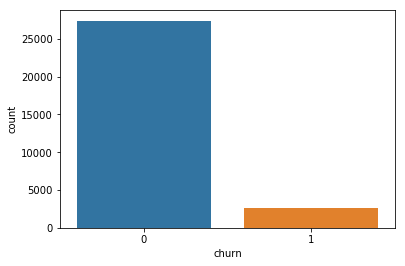

In [25]:
sns.countplot(x='churn', data=data)

As we observed earlier, churn rate is low in the overall dataset. So we would need to handle the class imbalance.

#### Age on Network (aon)

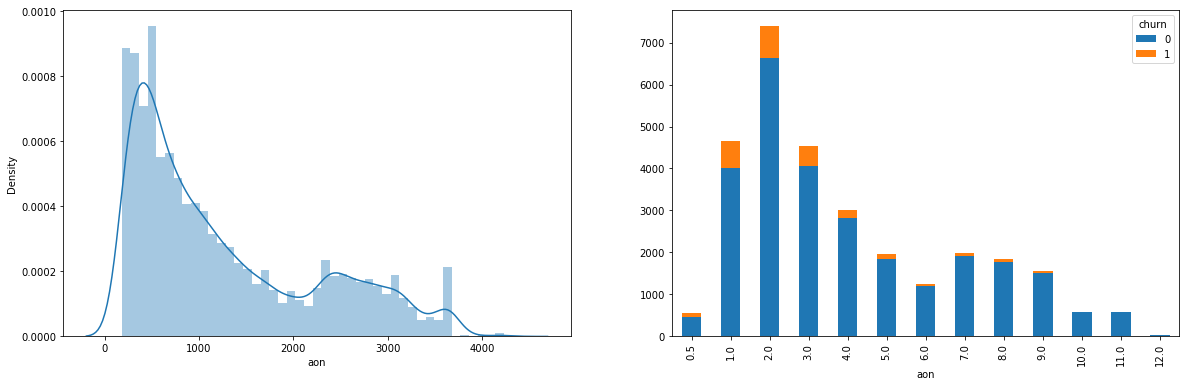

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 6))

# distribution plot for aon
sns.distplot(data['aon'], ax=ax1)

# bin the aon column with yearwise segments and plot the counts for each segments
bins = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
pd.crosstab(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), data['churn']).plot(kind='bar', stacked=True, ax = ax2)

* We could see more number of observations between 1 and 3 years.
* Also churn rate is high during this range than the others.

#### Incoming Calls Usage

,loc_ic_mou_6,std_ic_mou_6,isd_ic_mou_6,roam_ic_mou_6,spl_ic_mou_6,ic_others_6,total_ic_mou_6
count,29979.000000,29979.000000,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000
mean,244.064853,51.149589,11.14435,17.428073,0.066736,1.189804,307.624011
std,312.931377,140.564801,67.21659,79.192826,0.194321,13.994391,361.286101
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,56.710000,2.630000,0.00000,0.000000,0.000000,0.000000,90.035000
50%,151.080000,15.060000,0.00000,0.000000,0.000000,0.000000,205.340000
75%,315.620000,47.560000,0.00000,0.000000,0.000000,0.060000,393.835000
max,6496.110000,5459.630000,3965.69000,2613.310000,19.760000,1344.140000,6798.640000


,loc_ic_mou_7,std_ic_mou_7,isd_ic_mou_7,roam_ic_mou_7,spl_ic_mou_7,ic_others_7,total_ic_mou_7
count,29979.000000,29979.000000,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000
mean,247.713761,53.394721,12.34135,13.535270,0.018064,1.478162,314.954126
std,315.580778,149.236851,76.96167,76.343222,0.182005,15.414578,369.768358
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,63.550000,2.785000,0.00000,0.000000,0.000000,0.000000,98.840000
50%,154.860000,16.130000,0.00000,0.000000,0.000000,0.000000,211.240000
75%,316.785000,50.390000,0.00000,0.000000,0.000000,0.000000,396.915000
max,6466.740000,6745.760000,4747.91000,3813.290000,21.330000,1495.940000,7279.080000


,loc_ic_mou_8,std_ic_mou_8,isd_ic_mou_8,roam_ic_mou_8,spl_ic_mou_8,ic_others_8,total_ic_mou_8
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,234.331024,48.180997,11.688108,13.263074,0.027609,1.237346,295.472794
std,307.121461,141.009723,74.924529,74.588105,0.116422,12.894187,360.411762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.990000,1.430000,0.000000,0.000000,0.000000,0.000000,78.930000
50%,142.880000,12.560000,0.000000,0.000000,0.000000,0.000000,193.530000
75%,302.110000,43.435000,0.000000,0.000000,0.000000,0.060000,380.450000
max,5748.810000,5957.140000,4100.380000,4169.810000,6.230000,1209.860000,5990.710000


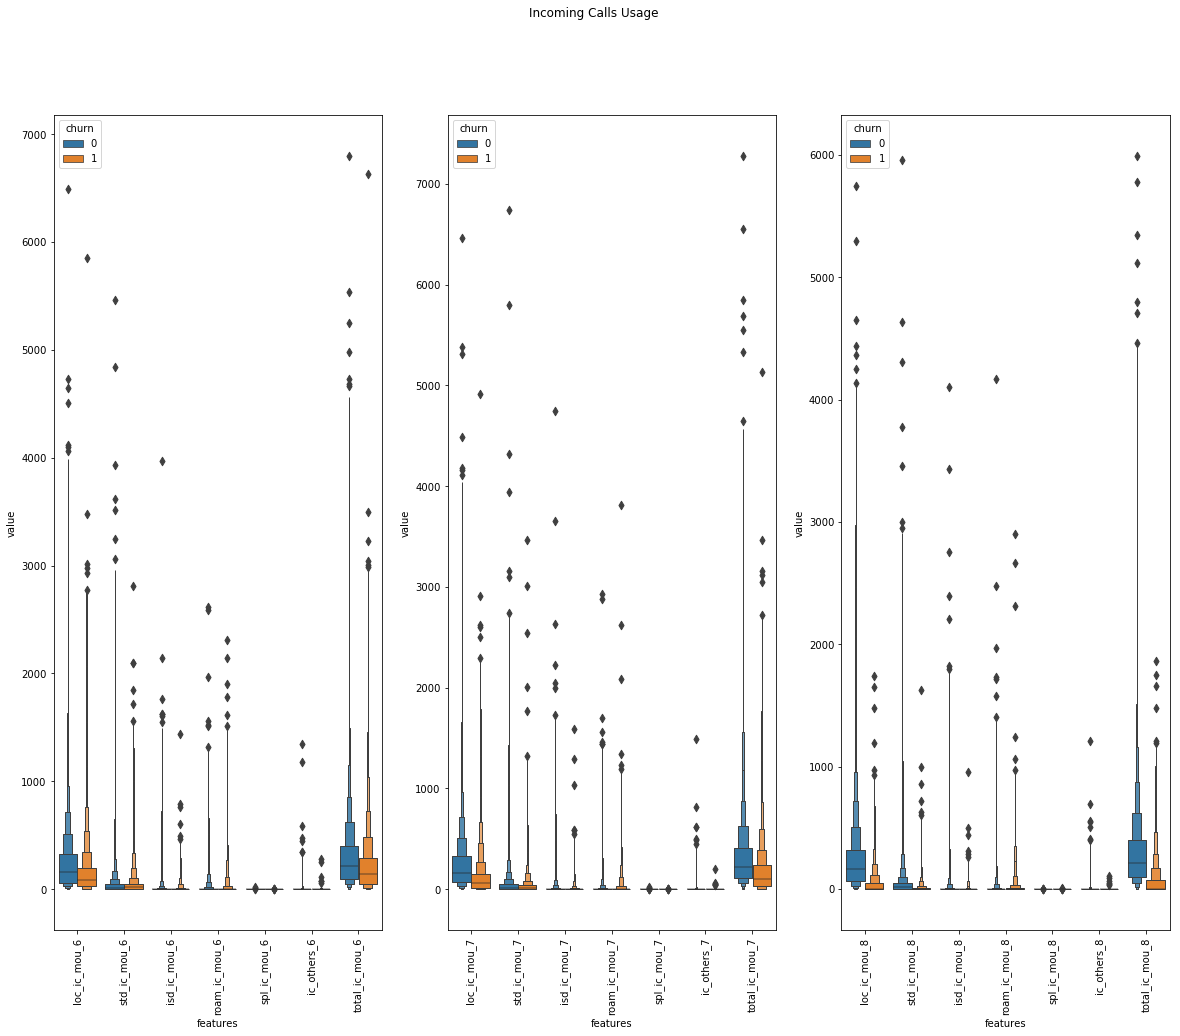

In [27]:
cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6','total_ic_mou_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7','total_ic_mou_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8','total_ic_mou_8']]

# column description stats
for i in range(0,3):
    display(data[cols[i]].describe())

# plot for the incoming calls usage
plt.figure(figsize=(20, 15))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxenplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage')

Almost all the Incoming calls usage columns seem to have outliers at the top percentile.

#### Outgoing Calls Usage

,loc_og_mou_6,std_og_mou_6,isd_og_mou_6,roam_og_mou_6,spl_og_mou_6,og_others_6,total_og_mou_6
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,283.058317,395.120001,2.266842,29.348362,5.920726,0.693200,687.068925
std,380.140057,606.718739,45.942529,118.629898,18.630406,2.282437,660.557039
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.010000,5.960000,0.000000,0.000000,0.000000,0.000000,266.480000
50%,166.330000,126.360000,0.000000,0.000000,0.210000,0.000000,510.760000
75%,374.600000,573.375000,0.000000,0.000000,5.170000,0.000000,899.960000
max,10643.380000,8432.990000,5900.660000,3775.110000,1023.210000,100.610000,10674.030000


,loc_og_mou_7,std_og_mou_7,isd_og_mou_7,roam_og_mou_7,spl_og_mou_7,og_others_7,total_og_mou_7
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,284.220111,415.617820,2.207826,22.056425,7.429822,0.047651,709.531995
std,375.993720,637.673317,45.642568,97.974803,23.076593,2.743248,685.283264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.710000,5.570000,0.000000,0.000000,0.000000,0.000000,275.275000
50%,170.460000,132.240000,0.000000,0.000000,0.780000,0.000000,526.130000
75%,376.035000,615.440000,0.000000,0.000000,7.130000,0.000000,931.305000
max,7674.780000,10936.730000,5490.280000,2812.040000,1265.790000,370.130000,11365.310000


,loc_og_mou_8,std_og_mou_8,isd_og_mou_8,roam_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8
count,29979.000000,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,261.305826,353.81534,2.029675,21.483542,6.889372,0.059194,624.107691
std,366.663849,616.45287,44.817776,106.294911,22.903352,3.322091,686.211375
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.280000,1.78000,0.000000,0.000000,0.000000,0.000000,188.965000
50%,148.280000,73.16000,0.000000,0.000000,0.500000,0.000000,435.810000
75%,348.340000,481.41000,0.000000,0.000000,6.380000,0.000000,833.435000
max,11039.910000,13980.06000,5681.540000,5337.040000,1390.880000,394.930000,14043.060000


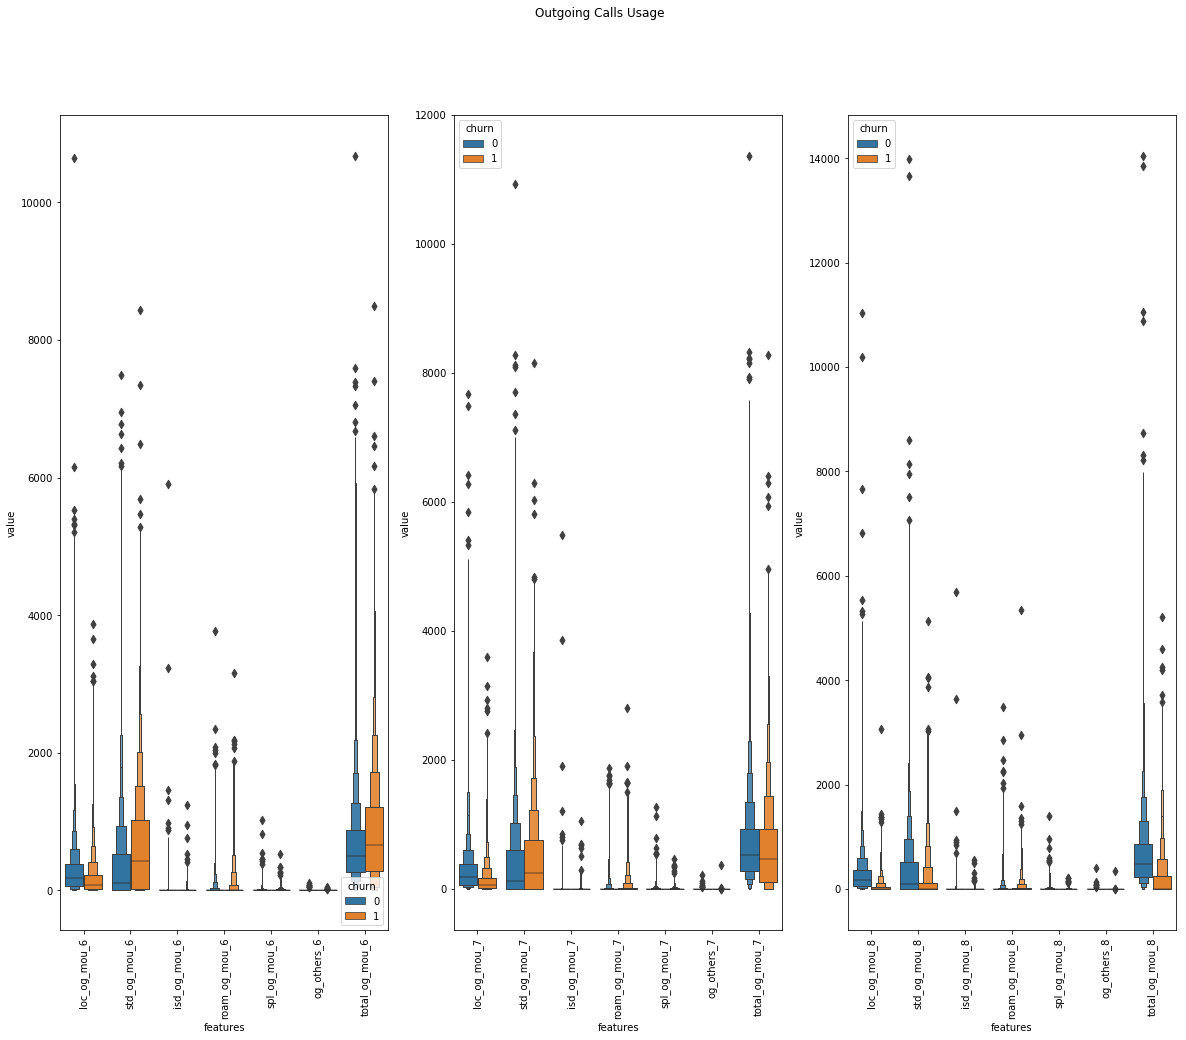

In [28]:
cols = [['loc_og_mou_6','std_og_mou_6','isd_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','isd_og_mou_7','roam_og_mou_7','spl_og_mou_7','og_others_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','isd_og_mou_8','roam_og_mou_8','spl_og_mou_8','og_others_8','total_og_mou_8']]

# column description stats
for i in range(0,3):
    display(data[cols[i]].describe())

# plot for the outgoing calls usage
plt.figure(figsize=(20, 15))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxenplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

Outgoing calls usage columns also seem to have outliers at the top percentile.

#### Operatorwise Calls Usage

,onnet_mou_6,offnet_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6
count,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,296.23634,418.127743,68.771712,159.678675,15.604617,16.238311,32.030383,2.876920
std,460.94123,470.773248,158.703140,222.093299,45.847694,78.899714,101.126970,19.938857
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.17000,137.340000,8.290000,33.460000,0.000000,0.000000,0.455000,0.000000
50%,125.89000,282.260000,29.140000,93.980000,1.960000,1.060000,7.090000,0.000000
75%,353.50000,523.625000,73.670000,202.920000,12.440000,10.285000,27.560000,0.180000
max,7376.71000,8362.360000,6351.440000,4693.860000,1678.410000,5459.560000,4630.230000,1351.110000


,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,94.733562,181.336751,6.979198,1.567723,189.892036,203.211564,2.012068
std,236.960935,250.231261,22.671604,6.892348,409.871710,413.660478,12.463715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.330000,30.290000,0.000000,0.000000,0.000000,1.600000,0.000000
50%,32.610000,101.280000,0.330000,0.000000,12.880000,37.760000,0.000000
75%,91.550000,240.230000,5.090000,0.000000,178.355000,211.210000,0.000000
max,6431.330000,4729.740000,1466.030000,342.860000,7366.580000,8314.760000,628.560000


,onnet_mou_7,offnet_mou_7,loc_ic_t2t_mou_7,loc_ic_t2m_mou_7,loc_ic_t2f_mou_7,std_ic_t2t_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,304.591922,424.103446,70.328939,160.855906,16.518919,16.906042,33.489321,2.995316
std,481.966821,486.710075,167.371389,219.513008,49.500859,84.734917,105.834745,20.521935
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.045000,135.690000,9.470000,38.130000,0.000000,0.000000,0.480000,0.000000
50%,125.560000,282.040000,30.130000,96.840000,2.210000,1.200000,7.480000,0.000000
75%,360.360000,532.905000,74.735000,203.535000,13.040000,10.990000,29.250000,0.260000
max,8157.780000,9667.130000,5709.590000,4388.730000,1983.010000,5800.930000,3470.380000,1136.080000


,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,std_og_t2t_mou_7,std_og_t2m_mou_7,std_og_t2f_mou_7
count,29979.000000,29979.000000,29979.000000,29979.00000,29979.000000,29979.000000,29979.000000
mean,95.787420,181.323574,7.100147,1.86379,200.060865,213.516733,2.035893
std,248.250149,240.815912,22.599153,9.26021,428.303583,438.106106,13.357273
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,9.130000,33.580000,0.000000,0.00000,0.000000,1.350000,0.000000
50%,33.190000,104.360000,0.400000,0.00000,13.440000,37.560000,0.000000
75%,91.535000,239.485000,5.260000,0.10000,191.660000,223.020000,0.000000
max,7400.660000,4557.140000,1196.430000,569.71000,8133.660000,9284.740000,544.630000


,onnet_mou_8,offnet_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,267.809147,375.159926,65.959031,153.649476,14.712935,15.061359,30.432842,2.683053
std,466.750205,477.656991,155.769286,217.059251,43.729954,72.469566,105.328660,20.280187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.070000,95.730000,6.810000,29.660000,0.000000,0.000000,0.000000,0.000000
50%,99.590000,241.040000,26.840000,89.830000,1.850000,0.560000,5.710000,0.000000
75%,298.215000,483.000000,70.360000,197.015000,11.610000,8.860000,25.330000,0.130000
max,10752.560000,14007.340000,4003.210000,5738.460000,1588.530000,4309.290000,5645.860000,1394.890000


,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,87.184563,167.616746,6.496088,1.714052,172.355233,179.665270,1.790935
std,234.833442,234.896621,20.228358,7.401177,410.213116,416.924325,11.706431
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.790000,22.420000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.640000,89.880000,0.160000,0.000000,5.960000,23.730000,0.000000
75%,84.700000,223.615000,4.680000,0.050000,133.210000,164.785000,0.000000
max,10752.560000,4961.330000,928.490000,351.830000,8014.430000,13950.040000,516.910000


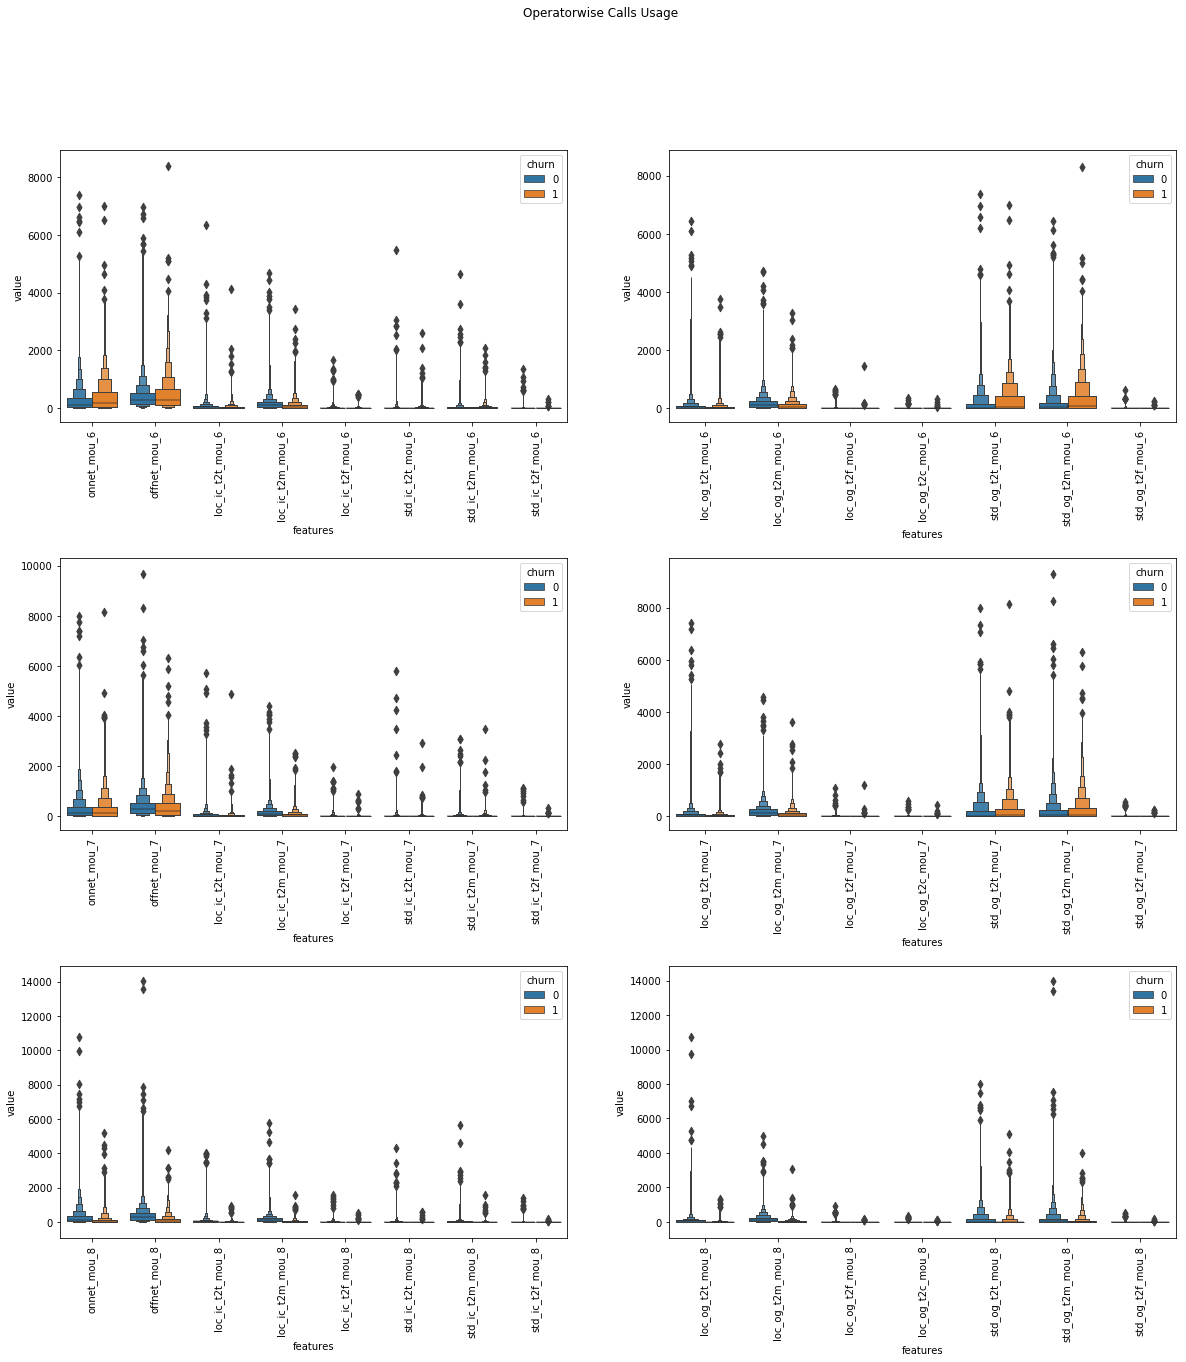

In [29]:
cols = [['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8']]

# column description stats
for i in range(0,6):
    display(data[cols[i]].describe())

# plot for the operatorwise calls usage
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
for i in range(0,6):
    plt.subplot(3,2,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxenplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Operatorwise Calls Usage')

Operatorwise calls usage columns also seem to have outliers at the top percentile.

#### Recharge Amount

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
count,29979.000000,29979.000000,29979.000000
mean,697.720204,696.309083,613.908403
std,539.488337,562.327538,602.047678
min,0.000000,0.000000,0.000000
25%,433.000000,427.000000,309.000000
50%,585.000000,581.000000,520.000000
75%,838.000000,836.000000,790.000000
max,35190.000000,40335.000000,45320.000000


,total_rech_amt_voice_6,total_rech_amt_voice_7,total_rech_amt_voice_8
count,29979.000000,29979.000000,29979.000000
mean,608.614859,600.873285,526.838474
std,527.653094,547.550096,577.651964
min,0.000000,0.000000,0.000000
25%,352.000000,345.000000,232.000000
50%,516.000000,506.000000,441.000000
75%,755.000000,750.000000,700.000000
max,35190.000000,40335.000000,45320.000000


,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8
count,29979.000000,29979.000000,29979.000000
mean,90.788857,97.605184,89.803108
std,191.272837,198.435609,185.886834
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,154.000000,154.000000,145.000000
max,7546.000000,4365.000000,4061.000000


,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
count,29979.000000,29979.000000,29979.000000
mean,171.471130,175.723006,162.929351
std,174.762549,181.606909,172.671442
min,0.000000,0.000000,0.000000
25%,110.000000,110.000000,67.000000
50%,120.000000,128.000000,130.000000
75%,200.000000,200.000000,198.000000
max,4010.000000,4010.000000,4449.000000


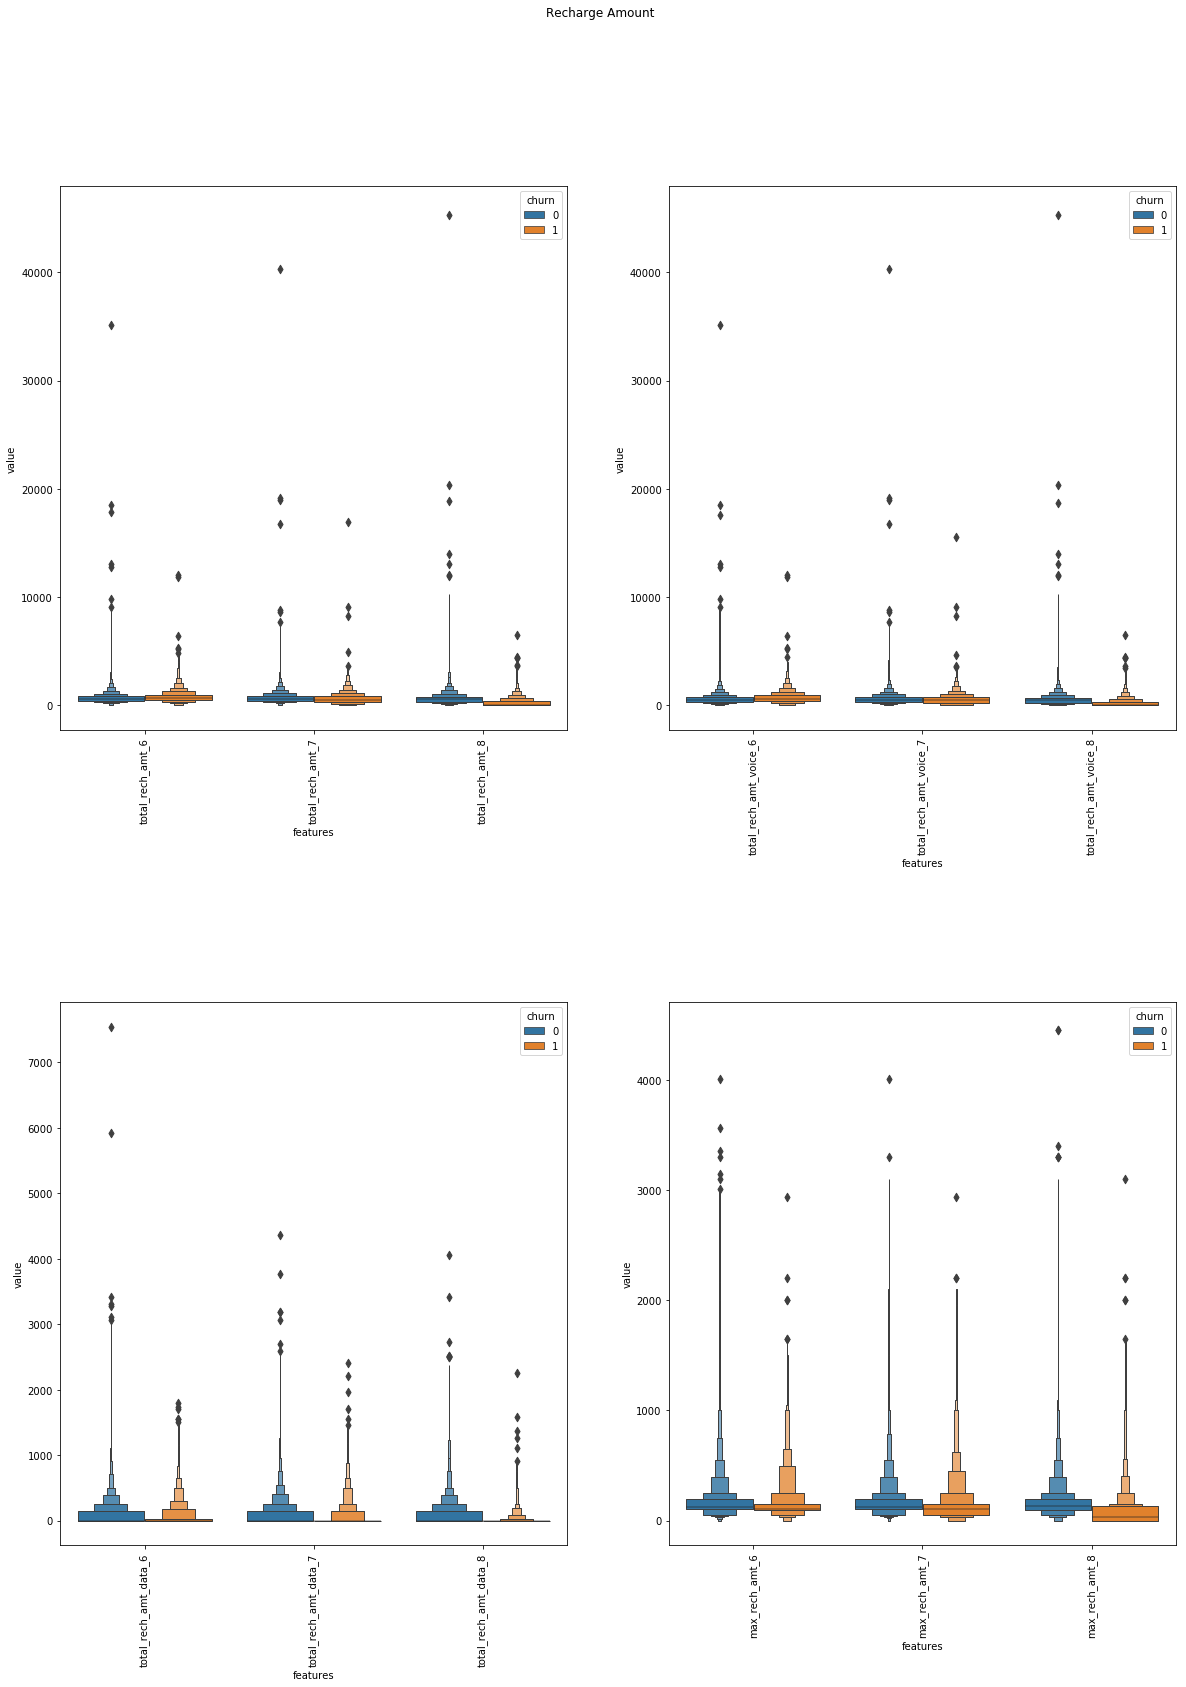

In [30]:
# Let's derive total recharge amount for voice with the diff recharge amount of total and data
data['total_rech_amt_voice_6'] = np.where((data['total_rech_amt_6'] >= data['total_rech_amt_data_6']), (data['total_rech_amt_6'] - data['total_rech_amt_data_6']), 0)
data['total_rech_amt_voice_7'] = np.where((data['total_rech_amt_7'] >= data['total_rech_amt_data_7']), (data['total_rech_amt_7'] - data['total_rech_amt_data_7']), 0)
data['total_rech_amt_voice_8'] = np.where((data['total_rech_amt_8'] >= data['total_rech_amt_data_8']), (data['total_rech_amt_8'] - data['total_rech_amt_data_8']), 0)

cols = [
        ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'],
        ['total_rech_amt_voice_6','total_rech_amt_voice_7','total_rech_amt_voice_8'],
        ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8'],
        ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
       ]

# column description stats
for i in range(0,4):
    display(data[cols[i]].describe())

# plot for the recharge amount columns
plt.figure(figsize=(20, 25))
plt.subplots_adjust(hspace=0.5)
for i in range(0,4):
    plt.subplot(2,2,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxenplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Amount')

Recharge amount columns also seem to have outliers at the top percentile.

#### Recharge Count

,total_rech_num_6,total_rech_num_7,total_rech_num_8
count,29979.000000,29979.000000,29979.000000
mean,12.123253,11.914207,10.226092
std,9.546424,9.605757,9.480012
min,0.000000,0.000000,0.000000
25%,6.000000,6.000000,4.000000
50%,9.000000,9.000000,8.000000
75%,15.000000,15.000000,13.000000
max,307.000000,138.000000,196.000000


,total_rech_data_6,total_rech_data_7,total_rech_data_8
count,29979.000000,29979.000000,29979.000000
mean,0.936889,1.053938,1.035425
std,2.176824,2.412950,2.405824
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,61.000000,54.000000,60.000000


,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,29979.000000,29979.000000,29979.000000
mean,56.949331,58.716702,55.276594
std,105.849744,108.176034,104.814186
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,98.000000,98.000000,56.000000
max,1555.000000,1555.000000,1555.000000


,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8
count,29979.000000,29979.000000,29979.000000
mean,0.624771,0.718303,0.721605
std,1.730741,1.930804,1.871110
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,39.000000,48.000000,44.000000


,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8
count,29979.000000,29979.000000,29979.000000
mean,0.312118,0.335635,0.313820
std,1.066232,1.176567,1.162114
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,29.000000,35.000000,45.000000


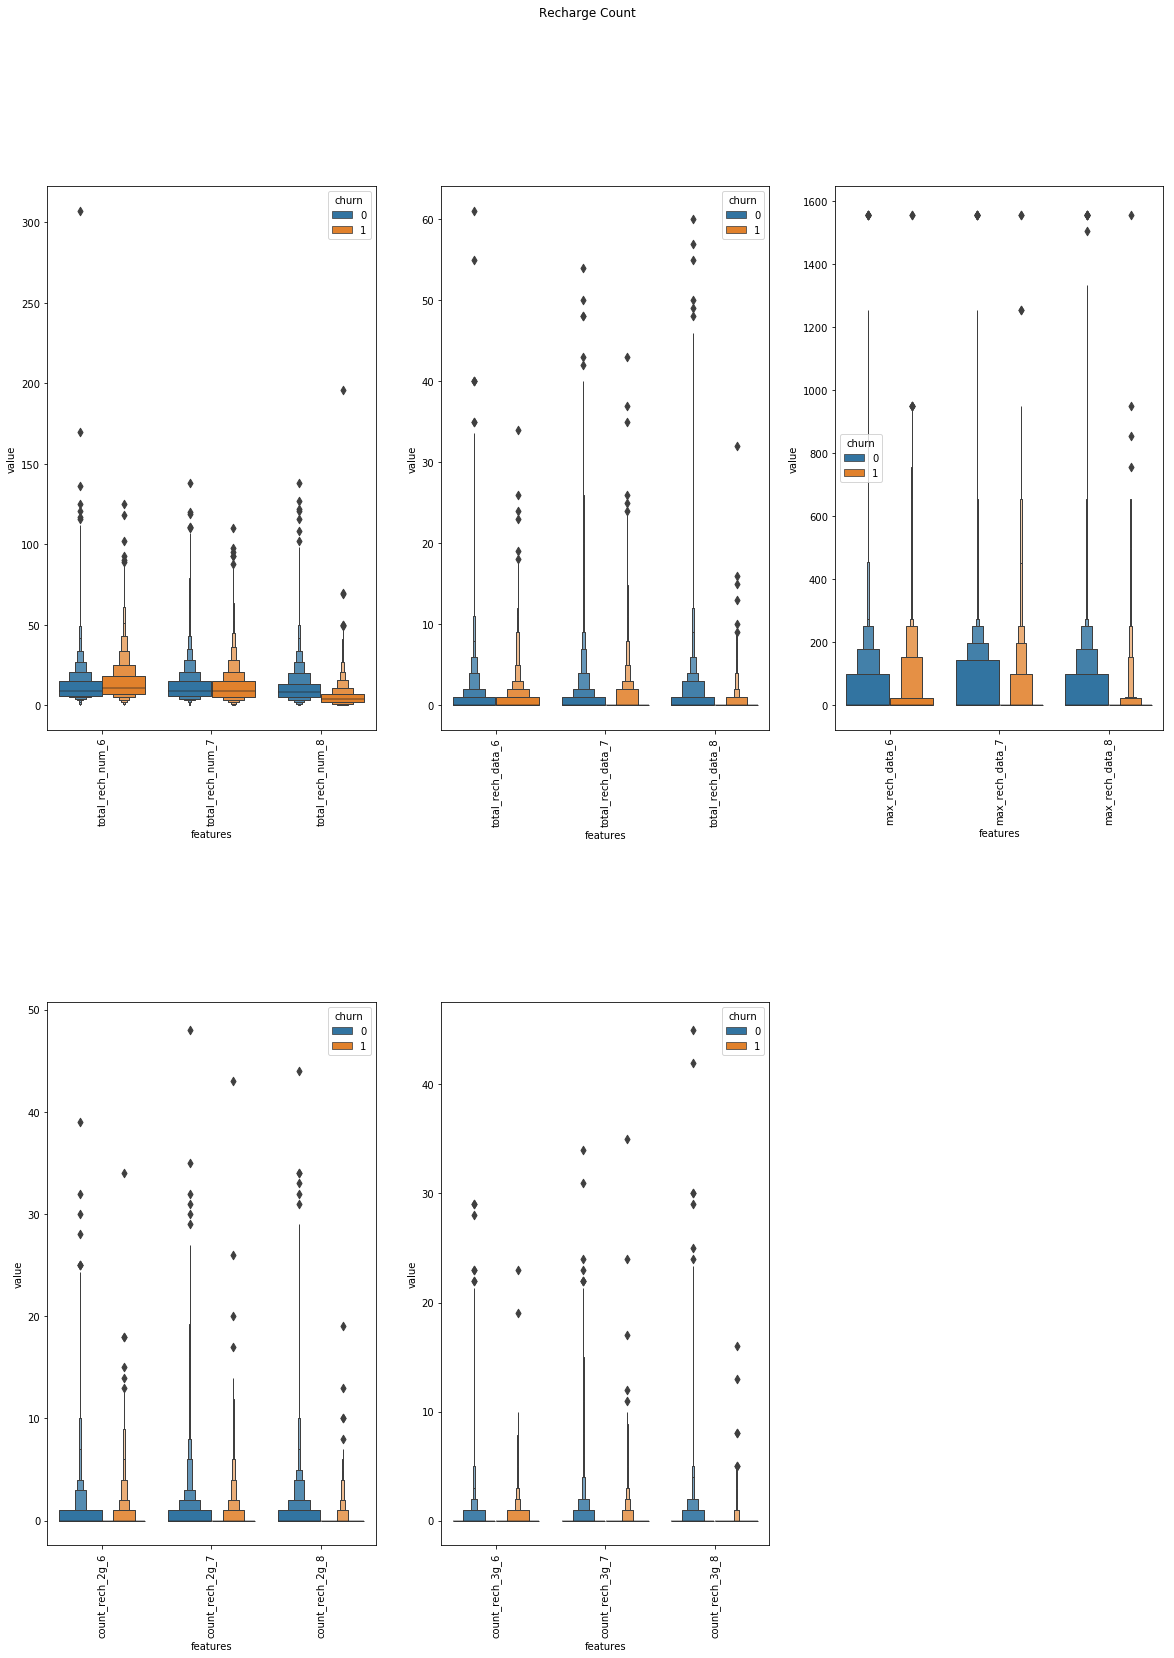

In [31]:
cols = [
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'],
        ['total_rech_data_6','total_rech_data_7','total_rech_data_8'],
        ['max_rech_data_6','max_rech_data_7','max_rech_data_8'],
        ['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8'],
        ['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'] 
       ]

# column description stats
for i in range(0,5):
    display(data[cols[i]].describe())

# plot for the recharge count columns
plt.figure(figsize=(20, 25))
plt.subplots_adjust(hspace=0.5)
for i in range(0,5):
    plt.subplot(2,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxenplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Count')

Recharge count columns also seem to have outliers at the top percentile.

#### Average Revenue per User (Arpu)

,arpu_6,arpu_7,arpu_8
count,29979.000000,29979.000000,29979.000000
mean,587.587624,589.424681,535.067748
std,442.848876,463.049067,492.447887
min,-2258.709000,-2014.045000,-945.808000
25%,364.352500,365.235000,289.782000
50%,495.951000,493.781000,452.232000
75%,704.184500,700.986000,671.349500
max,27731.088000,35145.834000,33543.624000


,arpu_2g_6,arpu_2g_7,arpu_2g_8
count,29979.000000,29979.000000,29979.000000
mean,50.280483,51.890691,47.866114
std,153.212614,157.959498,145.869033
min,-15.320000,-15.480000,-24.430000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,2.215000,2.375000,0.605000
max,6433.760000,4809.360000,3467.170000


,arpu_3g_6,arpu_3g_7,arpu_3g_8
count,29979.000000,29979.000000,29979.000000
mean,54.043360,55.934679,52.160455
std,171.872571,176.375885,163.905193
min,-30.280000,-26.040000,-20.040000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,6362.280000,4980.900000,3716.900000


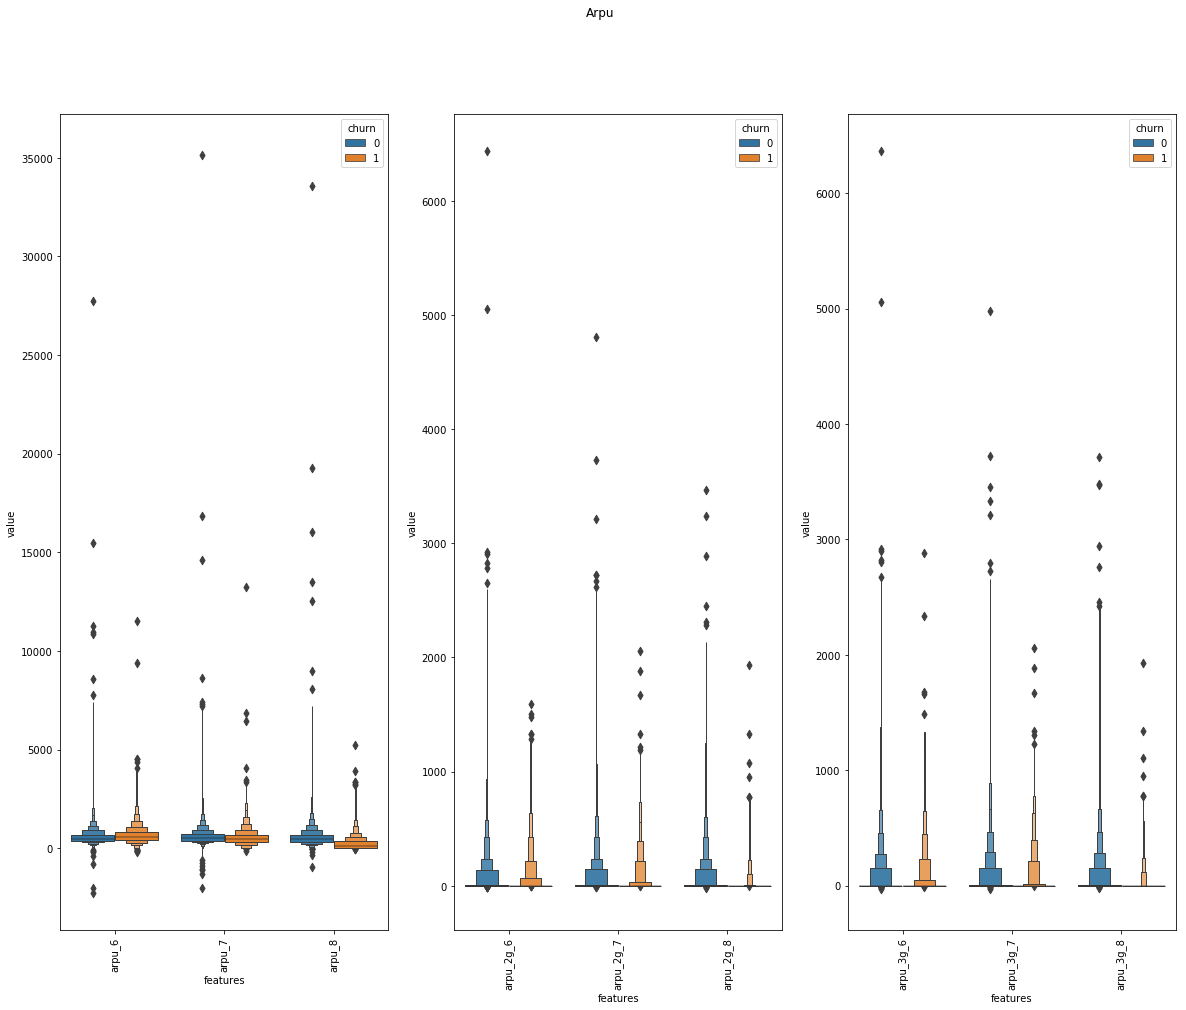

In [32]:
cols = [
        ['arpu_6','arpu_7','arpu_8'],
        ['arpu_2g_6','arpu_2g_7','arpu_2g_8'],
        ['arpu_3g_6','arpu_3g_7','arpu_3g_8']
       ]

# column description stats
for i in range(0,3):
    display(data[cols[i]].describe())

# plot for the arpu
plt.figure(figsize=(20, 15))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxenplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Arpu')

arpu columns also seem to have outliers at the top percentile.

#### 2G and 3G

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8
count,29979.000000,29979.000000,29979.000000
mean,78.875263,78.196804,69.248761
std,277.525473,280.430249,268.616268
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,14.470000,14.960000,9.625000
max,10285.900000,7873.550000,11117.610000


,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
count,29979.000000,29979.000000,29979.000000
mean,258.623297,278.341301,270.061116
std,866.619871,856.096362,859.715968
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,2.275000,0.000000
max,45735.400000,28144.120000,30036.060000


,night_pck_user_6,night_pck_user_7,night_pck_user_8
count,29979.000000,29979.000000,29979.000000
mean,1.250709,1.232529,1.226025
std,0.962706,0.967516,0.969349
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


,fb_user_6,fb_user_7,fb_user_8
count,29979.000000,29979.000000,29979.000000
mean,1.581274,1.568498,1.544648
std,0.566739,0.575308,0.612733
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


,monthly_2g_6,monthly_2g_7,monthly_2g_8
count,29979.000000,29979.000000,29979.000000
mean,0.124954,0.131425,0.114080
std,0.374656,0.387793,0.357335
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,4.000000,5.000000,5.000000


,monthly_3g_6,monthly_3g_7,monthly_3g_8
count,29979.000000,29979.000000,29979.000000
mean,0.174055,0.185296,0.173321
std,0.574545,0.620703,0.583178
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,14.000000,16.000000,16.000000


,sachet_2g_6,sachet_2g_7,sachet_2g_8
count,29979.000000,29979.000000,29979.000000
mean,0.499817,0.586877,0.607525
std,1.698845,1.900280,1.844605
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,39.000000,48.000000,44.000000


,sachet_3g_6,sachet_3g_7,sachet_3g_8
count,29979.000000,29979.000000,29979.000000
mean,0.138063,0.150339,0.140498
std,0.875984,0.969779,0.975212
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,29.000000,35.000000,41.000000


,jun_vbc_3g,jul_vbc_3g,aug_vbc_3g
count,29979.000000,29979.000000,29979.000000
mean,121.450911,135.225368,129.482436
std,389.910814,408.218570,390.625027
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,2.025000,1.600000
max,11166.210000,9165.600000,12916.220000


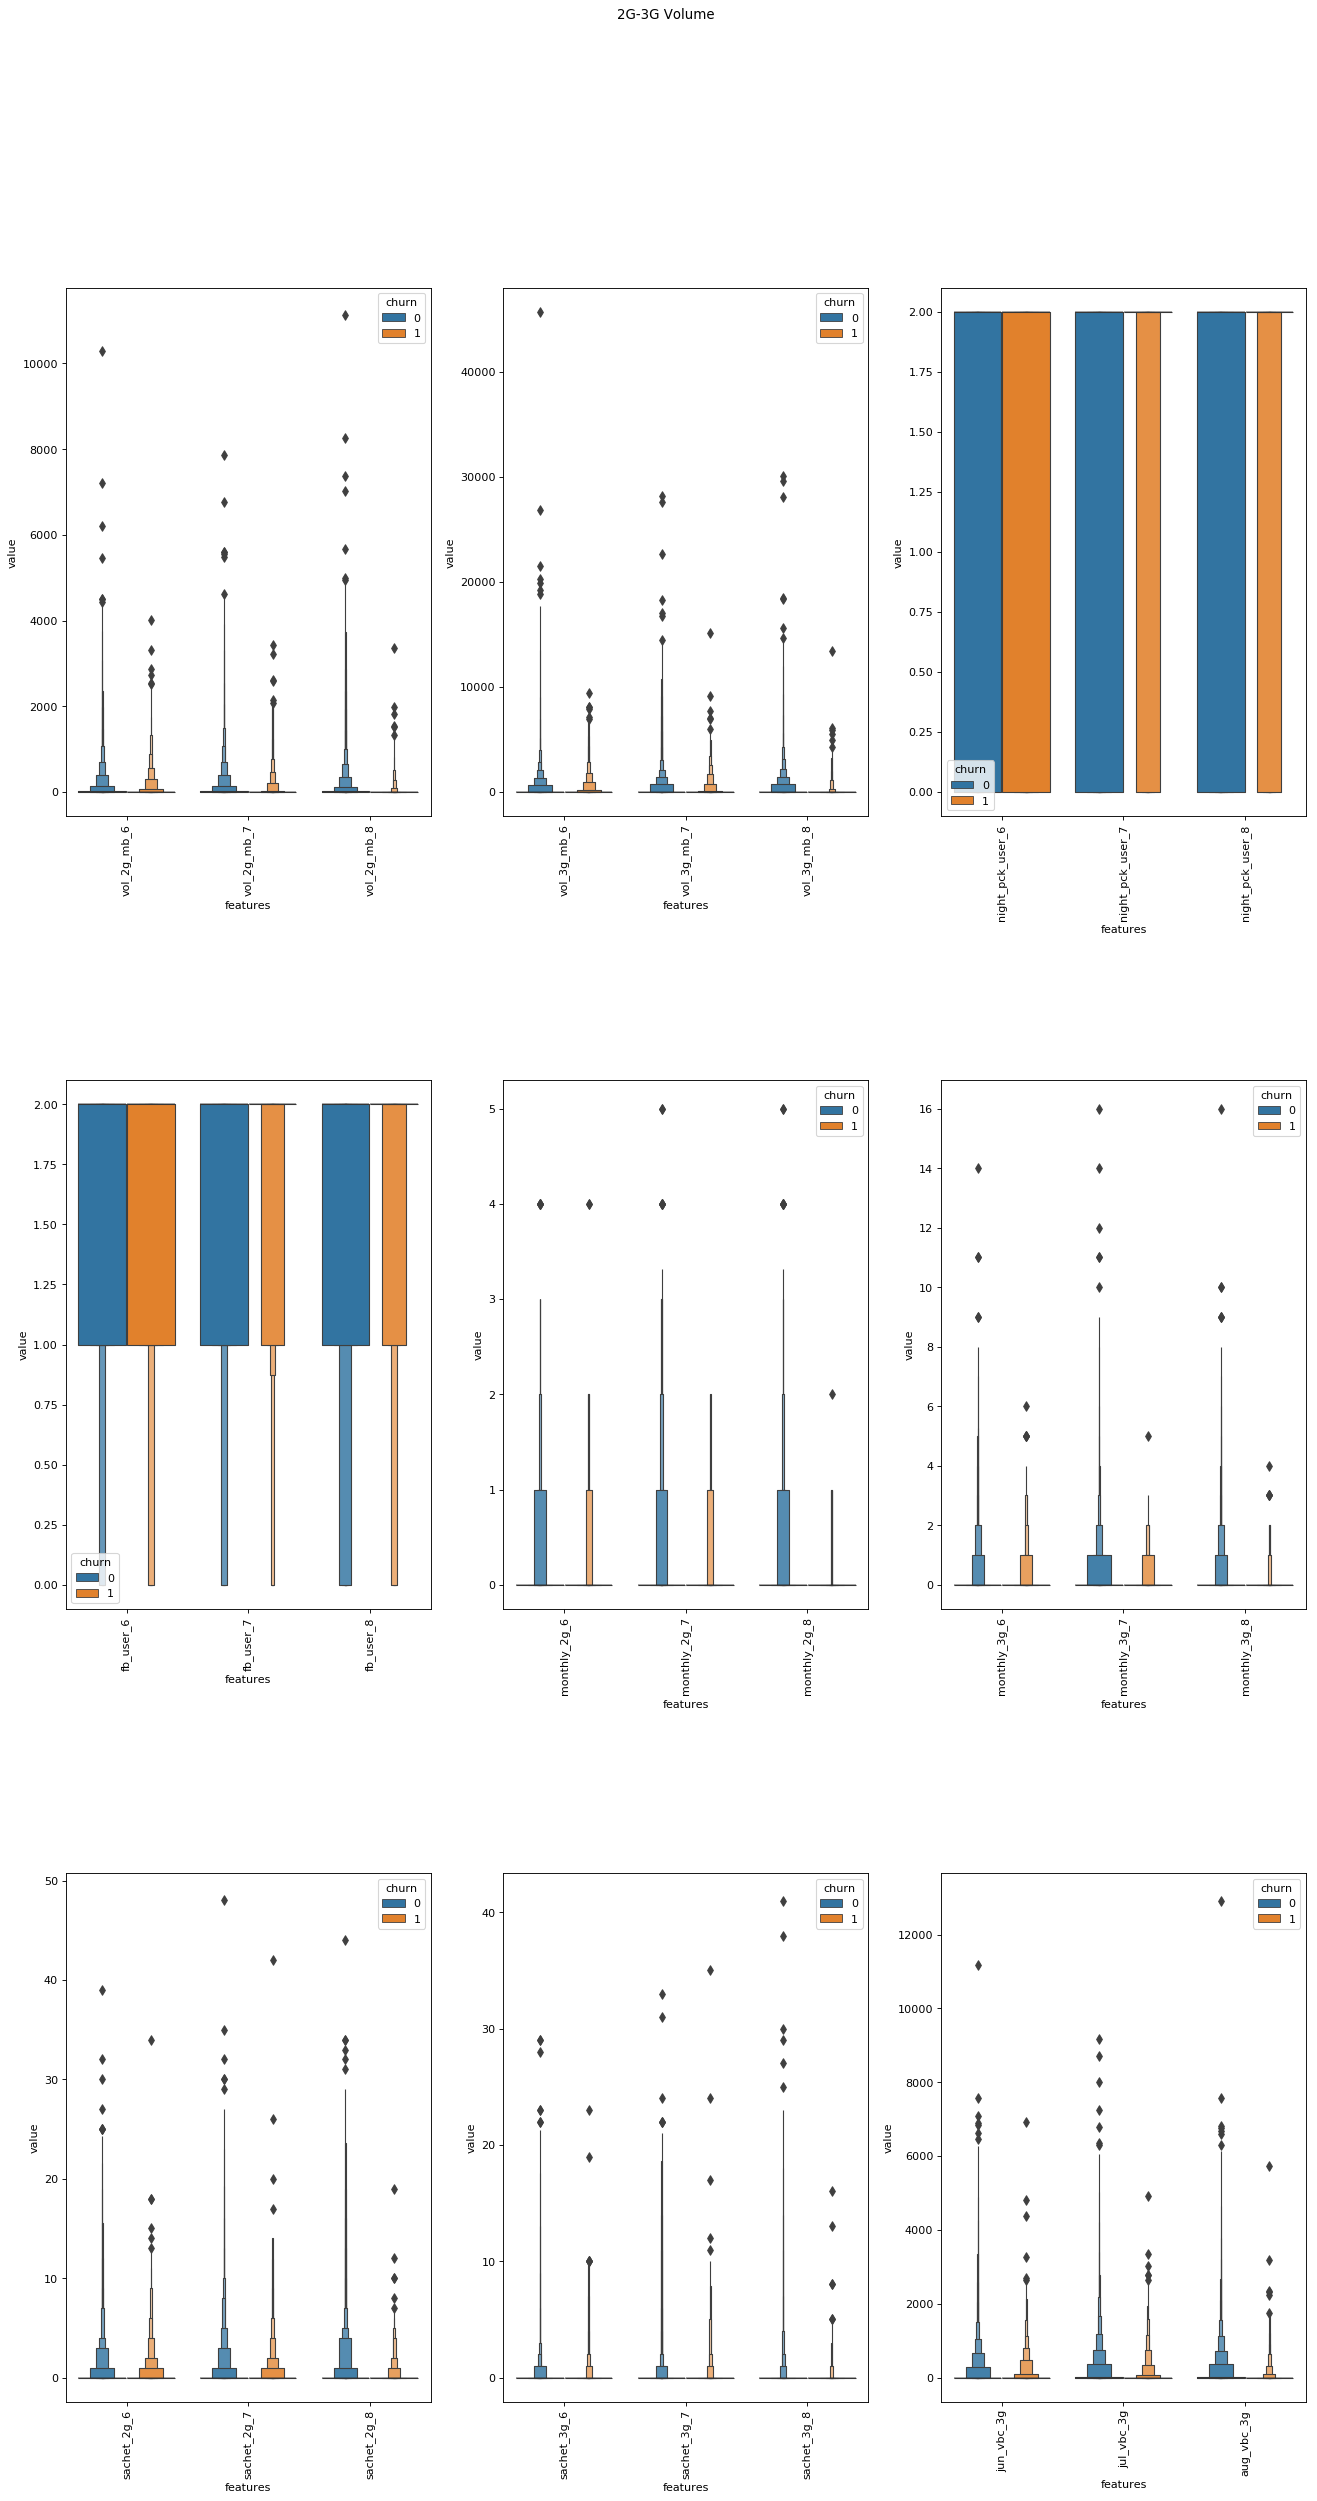

In [33]:
cols = [
        ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],
        ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
        ['night_pck_user_6','night_pck_user_7','night_pck_user_8'],
        ['fb_user_6','fb_user_7','fb_user_8'],
        ['monthly_2g_6','monthly_2g_7','monthly_2g_8'],
        ['monthly_3g_6','monthly_3g_7','monthly_3g_8'],
        ['sachet_2g_6','sachet_2g_7','sachet_2g_8'],
        ['sachet_3g_6','sachet_3g_7','sachet_3g_8'],
        ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']
       ]

# column description stats
for i in range(0,9):
    display(data[cols[i]].describe())

# plot for the 2g-3g volume
plt.figure(figsize=(20, 35),dpi=80)
plt.subplots_adjust(hspace=0.5)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxenplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('2G-3G Volume')

2G and 3G volume columns also seem to have outliers at the top percentile.

# Outliers Treatment

### Cap the outliers at the top percentile

We'll need to cap the outliers at the 99th percentile for the below columns.

In [34]:
cols_to_exclude = ['night_pck_user_6','night_pck_user_7','night_pck_user_8',
                   'fb_user_6','fb_user_7','fb_user_8',
                   'monthly_2g_6','monthly_2g_7','monthly_2g_8',
                   'monthly_3g_6','monthly_3g_7','monthly_3g_8',
                   'sachet_2g_6','sachet_2g_7','sachet_2g_8',
                   'sachet_3g_6','sachet_3g_7','sachet_3g_8',
                   'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8',
                   'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_og_mou_6','og_others_6','spl_og_mou_7','og_others_7','spl_og_mou_8','og_others_8',
                   'loc_og_t2c_mou_6','std_og_t2f_mou_6','std_ic_t2f_mou_6','loc_ic_t2f_mou_6',
                   'loc_og_t2c_mou_7','std_og_t2f_mou_7','std_ic_t2f_mou_7','loc_ic_t2f_mou_7',
                   'loc_og_t2c_mou_8','std_og_t2f_mou_8','std_ic_t2f_mou_8','loc_ic_t2f_mou_8',
                   'aon','churn'
                  ]
cols = list(set(data.columns).difference(set(cols_to_exclude)))

# iterate through the columns and cap the values with the 99th percentile
for col in cols:
    percentiles = data[col].quantile([0.01,0.99]).values
    #data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

### Remove the outliers

We'll need to remove the outliers at the 99th percentile for the below columns.

In [35]:
# remove the outliers with specific columns
data = data.loc[~(
                    ((data['roam_og_mou_8'] > 2200) & (data['churn'] == 1)) |
                    ((data['arpu_7'] > 10000) & (data['churn'] == 1)) |
                    ((data['loc_og_mou_8'] > 2000) & (data['churn'] == 1)) |
                    ((data['loc_ic_mou_7'] > 4000) & (data['churn'] == 1)) |
                    ((data['std_og_mou_7'] > 7000) & (data['churn'] == 1)) |
                    ((data['vol_2g_mb_8'] > 2500) & (data['churn'] == 1)) 
                 )
               ]

# Feature Engineering

### Date columns

Before we extract the date related columns, let's convert the columns to datetime type

In [36]:
# Convert date columns to date format
for col in date_cols:
    data[col] = pd.to_datetime(data[col], format='%m/%d/%Y')

Now, we'll extract the columns from last recharge date and last recharge data date.

In [37]:
cols = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
# get the recent date of recharge in the last 3 months
data['last_rech_date'] = data[cols].max(axis=1)
# get the number of days from the recent recharge date till the last date of august month
data['days_since_last_rech'] = np.floor(( pd.to_datetime('2014-08-31', format='%Y-%m-%d') - data['last_rech_date'] ).astype('timedelta64[D]'))
# fill the null values as 0
data['days_since_last_rech'] = data['days_since_last_rech'].fillna(0)

# subtract it from 3 to add higher weightage for values present in all the columns. 
# len(cols) = 3,  means present in all columns, 0 means not present in any column
data['rech_weightage'] = len(cols) - (data[cols].isnull().sum(axis=1))
data.drop(['last_rech_date','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1, inplace=True)


cols = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
# get the recent date of recharge data in the last 3 months
data['last_rech_data_date'] = data[cols].max(axis=1)
# get the number of days from the recent recharge data date till the last date of august month
data['days_since_last_data_rech'] = np.floor(( pd.to_datetime('2014-08-31', format='%Y-%m-%d') - data['last_rech_data_date'] ).astype('timedelta64[D]'))
# fill the null values as 0
data['days_since_last_data_rech'] = data['days_since_last_data_rech'].fillna(0)

# subtract it from 3 to add higher weightage for values present in all the columns. 
# len(cols) = 3, means present in all columns, 0 means not present in any column
data['rech_data_weightage'] = len(cols) - (data[cols].isnull().sum(axis=1))

# drop the unwanted columns
data.drop(['last_rech_data_date','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'], axis=1, inplace=True)

### Numeric Columns - call usage

Similarly, we'll extract the mean values of onnet and offnet columns for the last 3 months(jun,jul,aug)

In [38]:
# network columns
# get the mean of onnet mou in the last 3 months
cols = ['onnet_mou_6','onnet_mou_7','onnet_mou_8']
data['mean_onnet_mou'] = round(data[cols].mean(axis=1),2)

# get the mean of offnet mou in the last 3 months
cols = ['offnet_mou_6','offnet_mou_7','offnet_mou_8']
data['mean_offnet_mou'] = round(data[cols].mean(axis=1),2)

# get the mean total of both onnet and offnet mou in the last 3 months
data['mean_onnet_offnet_mou'] = data['mean_onnet_mou'] + data['mean_offnet_mou']

Let's extract the mean values of roam incoming and outgoing columns for the last 3 months(jun,jul,aug)

In [39]:
# Roaming columns
# get the mean of roam ic mou in the last 3 months
cols = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8']
data['mean_roam_ic_mou'] = round(data[cols].mean(axis=1),2)

# get the mean of roam og mou in the last 3 months
cols = ['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8']
data['mean_roam_og_mou'] = round(data[cols].mean(axis=1),2)

# get the mean total of both roam ic and og mou in the last 3 months
data['mean_roam_mou'] = data['mean_roam_ic_mou'] + data['mean_roam_og_mou']

Now extract the mean values of local incoming and outgoing columns for various operator types for the last 3 months(jun,jul,aug)

In [40]:
# loc-t2t columns
cols = ['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8']
data['mean_loc_ic_t2t_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8']
data['mean_loc_og_t2t_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_t2t_mou'] = data['mean_loc_ic_t2t_mou'] + data['mean_loc_og_t2t_mou']

In [41]:
# loc-t2m columns
cols = ['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8']
data['mean_loc_ic_t2m_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8']
data['mean_loc_og_t2m_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_t2m_mou'] = data['mean_loc_ic_t2m_mou'] + data['mean_loc_og_t2m_mou']

In [42]:
# loc-t2f columns
cols = ['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8']
data['mean_loc_ic_t2f_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8']
data['mean_loc_og_t2f_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_t2f_mou'] = data['mean_loc_ic_t2f_mou'] + data['mean_loc_og_t2f_mou']

In [43]:
# loc-t2c columns
cols = ['loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8']
data['mean_loc_og_t2c_mou'] = round(data[cols].mean(axis=1),2)

In [44]:
# std-t2t columns
cols = ['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8']
data['mean_std_ic_t2t_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8']
data['mean_std_og_t2t_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_t2t_mou'] = data['mean_std_ic_t2t_mou'] + data['mean_std_og_t2t_mou']

In [45]:
# std-t2m columns
cols = ['std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8']
data['mean_std_ic_t2m_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8']
data['mean_std_og_t2m_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_t2m_mou'] = data['mean_std_ic_t2m_mou'] + data['mean_std_og_t2m_mou']

In [46]:
# std-t2f columns
cols = ['std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8']
data['mean_std_ic_t2f_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8']
data['mean_std_og_t2f_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_t2f_mou'] = data['mean_std_ic_t2f_mou'] + data['mean_std_og_t2f_mou']

In [47]:
# loc columns
cols = ['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8']
data['mean_loc_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8']
data['mean_loc_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_mou'] = data['mean_loc_ic_mou'] + data['mean_loc_og_mou']

In [48]:
# std columns
cols = ['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8']
data['mean_std_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_mou_6','std_og_mou_7','std_og_mou_8']
data['mean_std_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_mou'] = data['mean_std_ic_mou'] + data['mean_std_og_mou']

In [49]:
# isd columns
cols = ['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8']
data['mean_isd_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8']
data['mean_isd_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_isd_mou'] = data['mean_isd_ic_mou'] + data['mean_isd_og_mou']

In [50]:
# spl columns
cols = ['spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8']
data['mean_spl_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['spl_og_mou_6','spl_og_mou_7','spl_og_mou_8']
data['mean_spl_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_spl_mou'] = data['mean_spl_ic_mou'] + data['mean_spl_og_mou']

In [51]:
# others columns
cols = ['ic_others_6','ic_others_7','ic_others_8']
data['mean_ic_others_mou'] = round(data[cols].mean(axis=1),2)

cols = ['og_others_6','og_others_7','og_others_8']
data['mean_og_others_mou'] = round(data[cols].mean(axis=1),2)

data['mean_others_mou'] = data['mean_ic_others_mou'] + data['mean_og_others_mou']

* Let's extract the mean values for incoming and outgoing columns for the last 3 months(jun,jul,aug)
* Also extract the weightage for incoming and outgoing columns for the last 3 months(jun,jul,aug) in the increasing order

In [52]:
# total columns
cols = ['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']
data['mean_total_ic_mou'] = round(data[cols].mean(axis=1),2)
# Weightage for ic for the last 3 months
df = data[cols].astype(bool)
data['total_ic_weightage'] = ( df['total_ic_mou_6'] * 1 ) + ( df['total_ic_mou_7'] * 10 ) + ( df['total_ic_mou_8'] * 100 )

cols = ['total_og_mou_6','total_og_mou_7','total_og_mou_8']
data['mean_total_og_mou'] = round(data[cols].mean(axis=1),2)
# Weightage for og for the last 3 months
df = data[cols].astype(bool)
data['total_og_weightage'] = ( df['total_og_mou_6'] * 1 ) + ( df['total_og_mou_7'] * 10 ) + ( df['total_og_mou_8'] * 100 )

data['mean_total_mou'] = data['mean_total_ic_mou'] + data['mean_total_og_mou']

data['mean_total_mou_6'] = round(data[['total_ic_mou_6','total_og_mou_6']].mean(axis=1),2)
data['mean_total_mou_7'] = round(data[['total_ic_mou_7','total_og_mou_7']].mean(axis=1),2)
data['mean_total_mou_8'] = round(data[['total_ic_mou_8','total_og_mou_8']].mean(axis=1),2)

### Numeric Columns - Recharge

Similarly, we'll extract the mean, min, max values of recharge related columns for the last 3 months(jun,jul,aug)

In [53]:
# total_rech_num columns
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
# mean of total recharge number
data['mean_total_rech_num'] = round(data[cols].mean(axis=1),2)
# Minimum of total recharge number
data['min_total_rech_num'] = data[cols].min(axis=1)
# Maximum of total recharge number
data['max_total_rech_num'] = data[cols].max(axis=1)

In [54]:
# total_rech_amt columns
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
data['mean_total_rech_amt'] = round(data[cols].mean(axis=1),2)
data['min_total_rech_amt'] = data[cols].min(axis=1)
data['max_total_rech_amt'] = data[cols].max(axis=1)

In [55]:
# max_rech_amt columns
cols = ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
data['mean_max_rech_amt'] = round(data[cols].mean(axis=1),2)

# last_day_rch_amt columns
cols = ['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8']
data['mean_last_day_rch_amt'] = round(data[cols].mean(axis=1),2)

In [56]:
# total_rech_data columns
cols = ['total_rech_data_6','total_rech_data_7','total_rech_data_8']
data['mean_total_rech_data'] = round(data[cols].mean(axis=1),2)
data['min_total_rech_data'] = data[cols].min(axis=1)
data['max_total_rech_data'] = data[cols].max(axis=1)

In [57]:
# total_rech_amt_data columns
cols = ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8']
data['mean_total_rech_amt_data'] = round(data[cols].mean(axis=1),2)
data['min_total_rech_amt_data'] = data[cols].min(axis=1)
data['max_total_rech_amt_data'] = data[cols].max(axis=1)

In [58]:
# total_rech_voice columns
data['mean_total_rech_voice'] = data['mean_total_rech_num'] - data['mean_total_rech_data']
data['min_total_rech_voice'] = data['min_total_rech_num'] - data['min_total_rech_data']
data['max_total_rech_voice'] = data['max_total_rech_num'] - data['max_total_rech_data']

In [59]:
# total_rech_amt_voice columns
data['mean_total_rech_amt_voice'] = data['mean_total_rech_amt'] - data['mean_total_rech_amt_data']
data['min_total_rech_amt_voice'] = data['min_total_rech_amt'] - data['min_total_rech_amt_data']
data['max_total_rech_amt_voice'] = data['max_total_rech_amt'] - data['max_total_rech_amt_data']

In [60]:
# max_rech_data columns
cols = ['max_rech_data_6','max_rech_data_7','max_rech_data_8']
data['mean_max_rech_data'] = round(data[cols].mean(axis=1),2)

# count_rech_2g columns
cols = ['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8']
data['mean_count_rech_2g'] = round(data[cols].mean(axis=1),2)

# count_rech_3g columns
cols = ['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8']
data['mean_count_rech_3g'] = round(data[cols].mean(axis=1),2)

Let's extract the weightage for recharge count and amount columns for the last 3 months(jun,jul,aug) in the increasing order

In [61]:
#get recharge num weightage for the last three months
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
df = data[cols].astype(bool)
data['rech_num_weightage'] = ( df['total_rech_num_6'] * 1 ) + ( df['total_rech_num_7'] * 10 ) + ( df['total_rech_num_8'] * 100 )

In [62]:
#get recharge amount weightage for the last three months
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
df = data[cols].astype(bool)
data['rech_amt_weightage'] = ( df['total_rech_amt_6'] * 1 ) + ( df['total_rech_amt_7'] * 10 ) + ( df['total_rech_amt_8'] * 100 )

In [63]:
# arpu columns
# ARPU = Total Revenue / Average Subscribers
cols = ['arpu_6','arpu_7','arpu_8']
data['mean_arpu'] = round(data[cols].mean(axis=1),2)

cols = ['arpu_2g_6','arpu_2g_7','arpu_2g_8']
data['mean_arpu_2g_data'] = round(data[cols].mean(axis=1),2)

cols = ['arpu_3g_6','arpu_3g_7','arpu_3g_8']
data['mean_arpu_3g_data'] = round(data[cols].mean(axis=1),2)

cols = ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8']
data['mean_vol_2g_mb_data'] = round(data[cols].mean(axis=1),2)

cols = ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']
data['mean_vol_3g_mb_data'] = round(data[cols].mean(axis=1),2)

In [64]:
#get night_pck_user weightage for the last three months
cols = ['night_pck_user_6','night_pck_user_7','night_pck_user_8']
data['night_pck_weightage'] = ( data['night_pck_user_6'] * 1 ) + ( data['night_pck_user_7'] * 10 ) + ( data['night_pck_user_8'] * 100 )

In [65]:
#get fb_user weightage for the last three months
cols = ['fb_user_6','fb_user_7','fb_user_8']
data['fb_user_weightage'] = ( data['fb_user_6'] * 1 ) + ( data['fb_user_7'] * 10 ) + ( data['fb_user_8'] * 100 )

In [66]:
#get vbc mean for the last three months
cols = ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']
data['mean_vbc_3g'] = round(data[cols].mean(axis=1),2)

In [67]:
#get monthly pack weightage for the last three months
data['monthly_2g_weightage'] = ( data['monthly_2g_6'] * 1 ) + ( data['monthly_2g_7'] * 10 ) + ( data['monthly_2g_8'] * 100 )
data['monthly_3g_weightage'] = ( data['monthly_3g_6'] * 1 ) + ( data['monthly_3g_7'] * 10 ) + ( data['monthly_3g_8'] * 100 )

#get sachet pack weightage for the last three months
data['sachet_2g_weightage'] = ( data['sachet_2g_6'] * 1 ) + ( data['sachet_2g_7'] * 10 ) + ( data['sachet_2g_8'] * 100 )
data['sachet_3g_weightage'] = ( data['sachet_3g_6'] * 1 ) + ( data['sachet_3g_7'] * 10 ) + ( data['sachet_3g_8'] * 100 )

Now that we have all the necessary features, we can start select the important features, build the baseline models and evaluate them.

# Model 1 - Customer Churn Prediction

## Feature Selection and Dimesionality Reduction using PCA

First let us take a backup of the dataset, so we can use it later for Model 2

In [68]:
#Taking a backup of dataset for later use
master_df = data.copy()

Split the columns into categorical and numerical types

In [69]:
# prepare the dataset
churn = data['churn']
data = data.drop('churn', axis=1)

#split the columns into category and numerical
cat_cols = ['night_pck_user_6','monthly_2g_6','sachet_2g_6','monthly_3g_6','sachet_3g_6','fb_user_6',
            'night_pck_user_7','monthly_2g_7','sachet_2g_7','monthly_3g_7','sachet_3g_7','fb_user_7',
            'night_pck_user_8','monthly_2g_8','sachet_2g_8','monthly_3g_8','sachet_3g_8','fb_user_8'] 

num_cols = list(set(data.columns).difference(set(cat_cols)))

### Dummy encode the categorical features

Add columns for each category using dummy encoding and drop the original columns

In [70]:
# dummy encode the categorical columns
data = pd.concat([data,pd.get_dummies(data[cat_cols], drop_first=True)], axis=1)

# drop the original columns
data.drop(cat_cols, axis=1, inplace=True)

### Log Transform the numerical features

As almost all the features are positively skewed, we'll log transform the numerical features to neutralize the positive skewness in the dataset.

In [71]:
# log transform with constant 10000 for real numbers
data[num_cols] = np.log((10000 + data[num_cols]))
data = np.log((10000 + data))

### Standardize the numerical features

Now, we'll standardize(rescale) the numerical features so as to have mean as 0 and SD as 1 

In [72]:
#Standardize the numeric values
data[num_cols] = (( data[num_cols] - data[num_cols].mean() ) / data[num_cols].std())

Before we start building the model, we we'll check for the missing values once to ensure data is clean. 

In [73]:
# Check for missing values count
#data = data.replace([np.inf, -np.inf], np.nan)
df = data.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt


# Handle class imbalance using SMOTE or ADASYN

Since the churn rate is about less than 10% in the overall dataset, we will apply the class balancing technique to handle the imbalance.

Among the top Over sampling algorithms, let's compare the SMOTE and ADASYN methods.

- SMOTE : 
    1. **Synthetic Minority Over sampling Technique (SMOTE)** algorithm applies KNN approach where it selects K nearest neighbors, joins them and creates the synthetic samples in the space. 
    2. The algorithm takes the feature vectors and its nearest neighbors, computes the distance between these vectors. The difference is multiplied by random number between (0, 1) and it is added back to feature. 
    3. SMOTE algorithm is a pioneer algorithm and many other algorithms are derived from SMOTE

- ADASYN : 
    1. **ADAptive SYNthetic (ADASYN)** is based on the idea of adaptively generating minority data samples according to their distributions using K nearest neighbor. 
    2. The algorithm adaptively updates the distribution and there are no assumptions made for the underlying distribution of the data.  
    3. The algorithm uses Euclidean distance for KNN Algorithm. 
    4. The key difference between ADASYN and SMOTE is that the former uses a density distribution, as a criterion to automatically decide the number of synthetic samples that must be generated for each minority sample by adaptively changing the weights of the different minority samples to compensate for the skewed distributions. 
    5. The latter generates the same number of synthetic samples for each original minority sample.

We we'll go with ADASYN over SMOTE as SMOTE will introduce some more noise into dataset comparing to ADASYN

In [74]:
X = data
Y = churn

print('Class Balance count prior ovsersampling: ',Counter(Y))
adasyn = ADASYN(random_state=RANDOM_STATE)
X, Y = adasyn.fit_sample(X, Y)

print('Class Balance count post oversampling: ',Counter(Y))


Class Balance count prior ovsersampling:  Counter({0: 27390, 1: 2589})
Class Balance count post oversampling:  Counter({1: 27629, 0: 27390})


Note that the class is well balanced now. We can now split the train and test dataset.

# Split into train test 

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(38513, 225) (38513,)
(16506, 225) (16506,)


# PCA

Let's apply PCA on the training dataset for dimensionality reduction and feature selection.

In [76]:
#initialize the pca with randomized
pca = PCA(svd_solver='randomized', random_state=RANDOM_STATE)
# fit the training dataset
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

Draw the **screeplot** for the PCA components and pick the right number of PC components to build the model

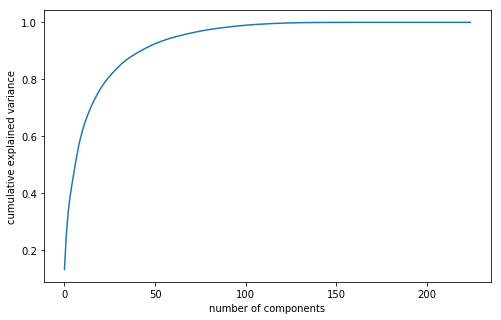

In [77]:
#Screeplot for the PCA components
%matplotlib inline
fig = plt.figure(figsize = (8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Chosen 50 PCA components for model building

In [78]:
# Initialize pca with 50 components
pca = PCA(n_components=50, random_state=RANDOM_STATE)
# fit and transform the training dataset
X_train_pca = pca.fit_transform(X_train)
# transform the testing dataset
X_test_pca = pca.transform(X_test)
# fit and transform the whole dataset
X_pca = pca.fit_transform(X)

# Baseline Model Building

In [79]:
# List to store the model scores
model_score_list = []

In [80]:
'''
Method Name : evaluate_model
Input(s)    : 2 series
Output(s)   : 4 float values  
Description :
- This method gets 2 series (actual and predicted) as inputs and compute the accuracy, ROC, Precision and Recall scores  
- Then returns the computed scores. 
'''
def evaluate_model(actual, pred):
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    rec_score = round(recall_score(actual, pred)*100,2)
    print('Recall score : ', rec_score)

    return acc_score, roc_score, prec_score, rec_score

### Logistic Regression

In [81]:
# Initialize the Logistic regression
model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the testing pca data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list 
model_score_list.append({'model_name':'LogisticRegression', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  79.96
ROC AUC score :  79.96
Precision score :  80.05
Recall score :  79.9


### RidgeClassifier

In [82]:
# initialize the Ridge Classifier
model = RidgeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'RidgeClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  79.8
ROC AUC score :  79.8
Precision score :  80.05
Recall score :  79.49


### SGDClassifier

In [83]:
# initialize the SGDClassifier
model = SGDClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'SGDClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  78.32
ROC AUC score :  78.32
Precision score :  77.48
Recall score :  79.96


### KNN

In [84]:
# initialize the KNeighbors classifiers
model = KNeighborsClassifier()
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'KNeighborsClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  88.54
ROC AUC score :  88.52
Precision score :  81.4
Recall score :  99.95


### LinearSVC

In [85]:
# initialize the LinearSVC
model = LinearSVC(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'LinearSVC', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  79.79
ROC AUC score :  79.79
Precision score :  79.26
Recall score :  80.79


### SVC

In [86]:
# initialize the SVC rbf kernel
model = SVC(kernel='rbf', class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'SVC_Kernel_rbf', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  90.22
ROC AUC score :  90.22
Precision score :  88.11
Recall score :  93.03


### Decision Tree

In [87]:
# initialize the Decision Tree
model = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'DecisionTreeClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  86.82
ROC AUC score :  86.81
Precision score :  84.96
Recall score :  89.54


### RandomForest

In [88]:
# initialize the randomforest
model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'RandomForestClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  95.65
ROC AUC score :  95.65
Precision score :  94.22
Recall score :  97.28


### ExtraTrees

In [89]:
# initialize the ExtraTreesClassifier
model = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'ExtraTreesClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  96.71
ROC AUC score :  96.71
Precision score :  95.49
Recall score :  98.06


### ADABoost

In [90]:
# initialize the AdaBoost
model = AdaBoostClassifier(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'AdaBoostClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  78.89
ROC AUC score :  78.89
Precision score :  79.03
Recall score :  78.74


### GradientBoosting

In [91]:
# initialize the GradientBoosting
model = GradientBoostingClassifier(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'GradientBoostingClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  82.68
ROC AUC score :  82.68
Precision score :  82.8
Recall score :  82.57


### XGBoosting

In [92]:
# Initialize the XGBoost
model = XGBClassifier(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'XGBClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

[17:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score :  94.14
ROC AUC score :  94.13
Precision score :  91.4
Recall score :  97.46


### Model score list

Let's view the models score list to select the top models

In [93]:
# convert the model scores to dataframe
model_score_df = pd.DataFrame(model_score_list,columns=['model_name', 'acc_score', 'roc_score','precision_score','recall_score'])

# Order by highest recall score and roc_auc_score
model_score_df.sort_values(['recall_score','roc_score'], ascending=False)

,model_name,acc_score,roc_score,precision_score,recall_score
3,KNeighborsClassifier,88.54,88.52,81.40,99.95
8,ExtraTreesClassifier,96.71,96.71,95.49,98.06
11,XGBClassifier,94.14,94.13,91.40,97.46
7,RandomForestClassifier,95.65,95.65,94.22,97.28
5,SVC_Kernel_rbf,90.22,90.22,88.11,93.03
6,DecisionTreeClassifier,86.82,86.81,84.96,89.54
10,GradientBoostingClassifier,82.68,82.68,82.80,82.57
4,LinearSVC,79.79,79.79,79.26,80.79
2,SGDClassifier,78.32,78.32,77.48,79.96
0,LogisticRegression,79.96,79.96,80.05,79.90


### Top 3 Models based on recall_score are KNeighborsClassifier, SVC_Kernel_rbf and ExtraTreesClassifier

##### KNeighborsClassifier
- Variation between recall_score and precision_score seem to be high at about 18%.
- But recall_score is almost 100% and the roc_auc_score is bit low at 88.5% comparing to other top two classifiers

##### ExtraTreesClassifier
- There is a little(3%) variation in recall and precision score.
- Also The recall_score and the roc_auc_score is almost 3% varied.

##### XGBClassifier
- There is 6% variation in recall and precision score.
- Also the recall_score and the roc_auc_score is varied by almost 3%.

**Let's check for the overfitting among the top 3 models using cross validation and select a model**

# Cross Validation and Model Selection

Now we will do the cross validation for the top 3 models and select a model based on the mean score

In [94]:
# initialize Stratified KFold with 5 splits
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = RANDOM_STATE)

# Cross validation for KNeighborsClassifier
model = KNeighborsClassifier()
knn_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('KNeighborsClassifier cv_score_mean : ', round(knn_cv_scores.mean() * 100, 2))
print('KNeighborsClassifier cv_score_std : ', round(knn_cv_scores.std() * 100, 2))

# Cross validation for ExtraTreesClassifier
model = ExtraTreesClassifier(random_state=RANDOM_STATE)
etc_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('ExtraTreesClassifier cv_score_mean : ', round(etc_cv_scores.mean() * 100, 2))
print('ExtraTreesClassifier cv_score_std : ', round(etc_cv_scores.std() * 100, 2))


# Cross validation for XGBClassifier
model =  XGBClassifier(random_state=RANDOM_STATE)
xgb_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('XGBClassifier cv_score_mean : ', round(xgb_cv_scores.mean() * 100, 2))
print('XGBClassifier cv_score_std : ', round(xgb_cv_scores.std() * 100, 2))


KNeighborsClassifier cv_score_mean :  99.97
KNeighborsClassifier cv_score_std :  0.04
ExtraTreesClassifier cv_score_mean :  98.53
ExtraTreesClassifier cv_score_std :  0.12
XGBClassifier cv_score_mean :  97.78
XGBClassifier cv_score_std :  0.14


### Plot the cv scores for the above 3 models

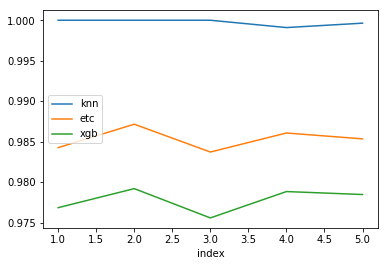

In [96]:
# plot the cv scores for the above 3 models
cv_scores_df = pd.DataFrame({'index':np.linspace(1,n_splits,n_splits),'knn':knn_cv_scores,'etc':etc_cv_scores,'xgb':xgb_cv_scores})
cv_scores_df.plot.line(x='index', y=['knn','etc','xgb'])


### Cross Validation results
##### KNeighborsClassifier
- Recall score is very consistent amoung all the folds

##### ExtraTreesClassifier
- This model seem to have lot of variations in recall score.

##### XGBClassifier
- This model has variations similar to ExtraTreesClassifier in recall score among all the folds validation.

**Since it is more important to identify churners than the non-churners accurately, we go with the KNeighborsClassifier which is consistent and also has high recall score**

# Hyperparameter Tuning for KNeighborsClassifier

Next we will tune the hyperparameters for the KNeighborsClassifier to find the best estimator

In [97]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.NeighborsBase, sklearn.neighbors._base.KNeighborsMixin, sklearn.neighbors._base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of t

In [98]:

# Hyperparameter Tuning for KNeighborsClassifier
# number of folds
n_splits = 5
# Number of neighbors
n_neighbors =  [int(x) for x in np.linspace(start = 1, stop = 3, num = 3)]
# Power parameter for the distance metric
p = [int(x) for x in np.linspace(start = 1, stop = 3, num = 3)]

# Create the parameter grid
params = {
            'n_neighbors': n_neighbors,
            'p': p
         }

# initialize the KNN model
model = KNeighborsClassifier(weights='uniform', n_jobs=-1)

# initialize the StratifiedKFold 
skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = RANDOM_STATE)

# initialize the RandomSearchCV
#grid = GridSearchCV(estimator=model, param_grid=params, scoring='recall', n_jobs=-1, cv=skf.split(X,Y), verbose=3 )
grid = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter = 1, scoring='recall', n_jobs=-1, cv=skf.split(X_pca,Y), verbose=3, random_state=RANDOM_STATE )

# fit the whole pca dataset
grid.fit(X_pca, Y)

# print the grid results
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished



 Best estimator:
KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

 Best score:
0.999276083606415

 Best parameters:
{'p': 2, 'n_neighbors': 3}


**The best recall score we got using RandomSearch is 99.92% and best param is p=2 with n_neighbors=3.**

**Now let's try fitting the best estimator and predict the results**


# Fitting the Best Estimator

In [99]:
# initialize the model with the best estimor
model = grid.best_estimator_

# fit the pca training dataset
model.fit(X_train_pca, Y_train)

# Predict the model with the pca testing dataset
Y_pred = model.predict(X_test_pca)

# get the predict probablities of pca testing dataset
Y_pred_proba = model.predict_proba(X_test_pca)

# Model Evaluation

In [100]:
'''
Method Name : plot_roc_curve
Input(s)    : 2 Series
Output(s)   : None  
Description :
- This method reads the Actual and predicted series of values
- Compute the roc_auc values
- Compute the roc_auc_score 
- Then plot the roc_auc curve. 
'''
def plot_roc_curve( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [101]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.80      0.89      8238
           1       0.83      1.00      0.91      8268

    accuracy                           0.90     16506
   macro avg       0.92      0.90      0.90     16506
weighted avg       0.92      0.90      0.90     16506


TN = 6562, FP = 1676, FN = 2, TP = 8266


Accuracy Score :  89.83
ROC AUC score :  89.82
Precision score :  83.14
Recall score :  99.98


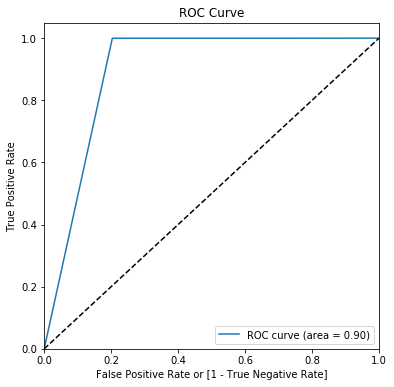

In [102]:
# ROC-AUC curve
plot_roc_curve(Y_test, Y_pred)

We have got the **recall score of 99.98%** with the best estimator which is slightly better than the Cross Validation mean score. Also the above Roc Curve seems to be in a good shape.

Nows let's see if we can optimize the cutoff further to **minimize the False Negatives**

### Optimal probability cutoff to minimize False Negatives

In [103]:
# Frame the dataset with the predicted probabilities
Y_pred_final = pd.DataFrame({'actual':Y_test,'pred_nonchurn_prob':Y_pred_proba[:,0],'pred_churn_prob':Y_pred_proba[:,1],'predicted':Y_pred})
Y_pred_final.head(5)

,actual,pred_nonchurn_prob,pred_churn_prob,predicted
53823,1,0.0,1.0,1
27131,0,1.0,0.0,0
48279,1,0.0,1.0,1
52297,1,0.0,1.0,1
39543,1,0.0,1.0,1


In [104]:
# create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    Y_pred_final[i]= Y_pred_final['pred_churn_prob'].map( lambda x: 1 if x > i else 0)
Y_pred_final.head()

,actual,pred_nonchurn_prob,pred_churn_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
53823,1,0.0,1.0,1,1,1,1,1,1,1,1,1,1,1
27131,0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0
48279,1,0.0,1.0,1,1,1,1,1,1,1,1,1,1,1
52297,1,0.0,1.0,1,1,1,1,1,1,1,1,1,1,1
39543,1,0.0,1.0,1,1,1,1,1,1,1,1,1,1,1


In [105]:
# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix( Y_pred_final['actual'], Y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.843027  0.685482  1.000000
0.1   0.1  0.843027  0.685482  1.000000
0.2   0.2  0.843027  0.685482  1.000000
0.3   0.3  0.843027  0.685482  1.000000
0.4   0.4  0.898340  0.796553  0.999758
0.5   0.5  0.898340  0.796553  0.999758
0.6   0.6  0.898340  0.796553  0.999758
0.7   0.7  0.946807  0.898762  0.994678
0.8   0.8  0.946807  0.898762  0.994678
0.9   0.9  0.946807  0.898762  0.994678


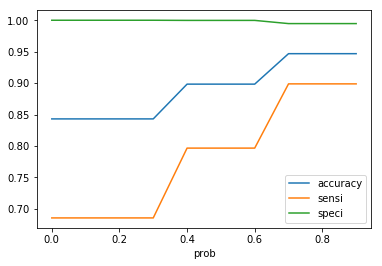

In [106]:
# plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

#### Now let's try with the cutoff of 0.3 and see if the False negatives can be reduced.

In [107]:
Y_pred_final['final_predicted'] = Y_pred_final['pred_churn_prob'].map( lambda x: 1 if x > 0.3 else 0)

# Final Model Evaluation

In [108]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred_final['final_predicted']))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_final['final_predicted']).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred_final['final_predicted'])


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.69      0.81      8238
           1       0.76      1.00      0.86      8268

    accuracy                           0.84     16506
   macro avg       0.88      0.84      0.84     16506
weighted avg       0.88      0.84      0.84     16506


TN = 5647, FP = 2591, FN = 0, TP = 8268


Accuracy Score :  84.3
ROC AUC score :  84.27
Precision score :  76.14
Recall score :  100.0


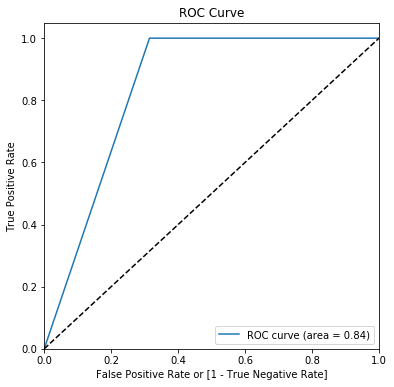

In [109]:
# ROC-AUC curve
plot_roc_curve(Y_test, Y_pred_final['final_predicted'])

### Observation

When the churn prediction probablity is at 0.5, we have 2 churned customers predicted as non churned and 1676 non churned customer predicted as churned. 

To make the 2 churned customers as churned, we have to adjust the probablity cutoff to 0.3 which increases the non churned customers predicted as churned to 2591 which is a considerable amount of increase in False Positive rate. 

**So we would recommend to go with the probablity cutoff of 0.5 as final prediction.**

# Model 2 - Identifying Strong Predictors of churn (Important features)

# Feature Selection using ExtraTreesClassifier

Let's prepare the dataset for model building

In [110]:
# Get the copy of the master_df and assign it in the dataset
data = master_df.copy()

churn = data['churn']
data = data.drop('churn', axis=1)

X = data
Y = churn

Next, we we'll fit the dataset in ExtraTreesClassifier and check for the features importance

In [111]:
# Fit the ExtraTreesClassifier model with default params
model = ExtraTreesClassifier(n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X, Y)

# Check the feature importance score for each feature
feature_imp_df = pd.DataFrame({'Feature':data.columns, 'Score':model.feature_importances_})
# Order the features by max score
feature_imp_df = feature_imp_df.sort_values('Score', ascending=False).reset_index()
feature_imp_df.head(50)

,index,Feature,Score
0,199,total_ic_weightage,0.079892
1,201,total_og_weightage,0.069146
2,230,rech_amt_weightage,0.047513
3,154,days_since_last_rech,0.013660
4,210,min_total_rech_amt,0.012795
5,59,loc_ic_t2m_mou_8,0.011501
6,205,mean_total_mou_8,0.011105
7,95,total_rech_amt_8,0.010763
8,101,last_day_rch_amt_8,0.010092
9,65,loc_ic_mou_8,0.010012


Now we will plot the top 50 important features with scores 

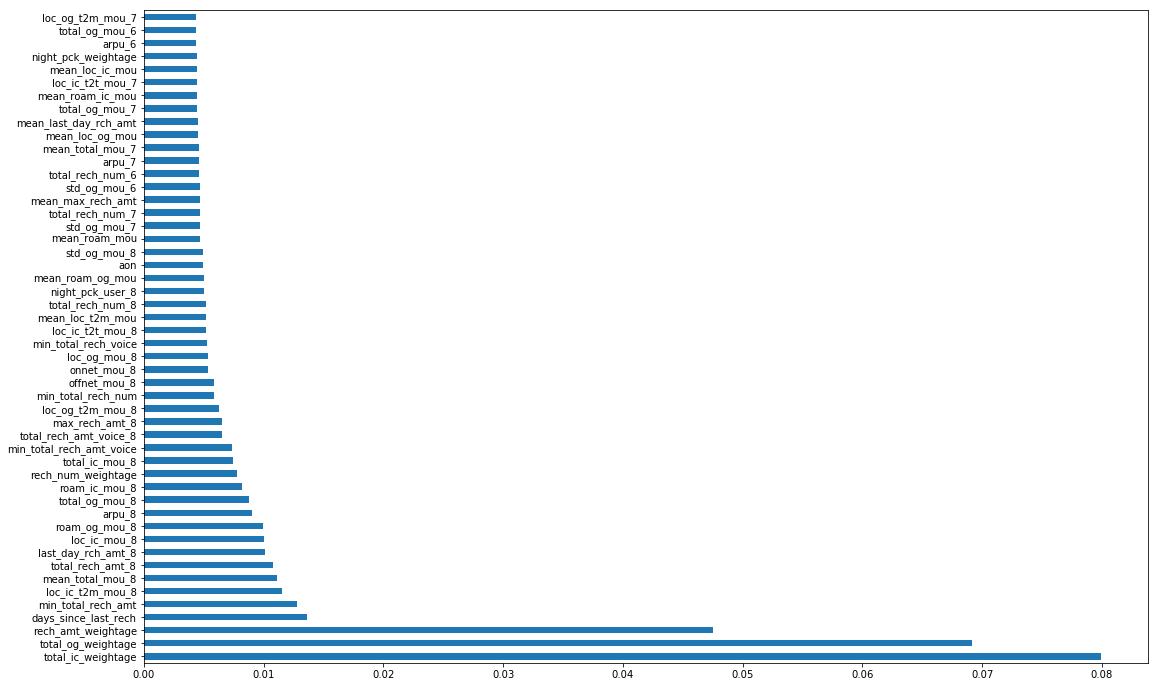

In [112]:
# plot the chart with top 50 important features
(pd.Series(model.feature_importances_, index=data.columns)
   .nlargest(50)
   .plot(kind='barh', figsize=(18,12))) 

Also plot the heat map for the top 50 features to check for the correlation between the independent features 

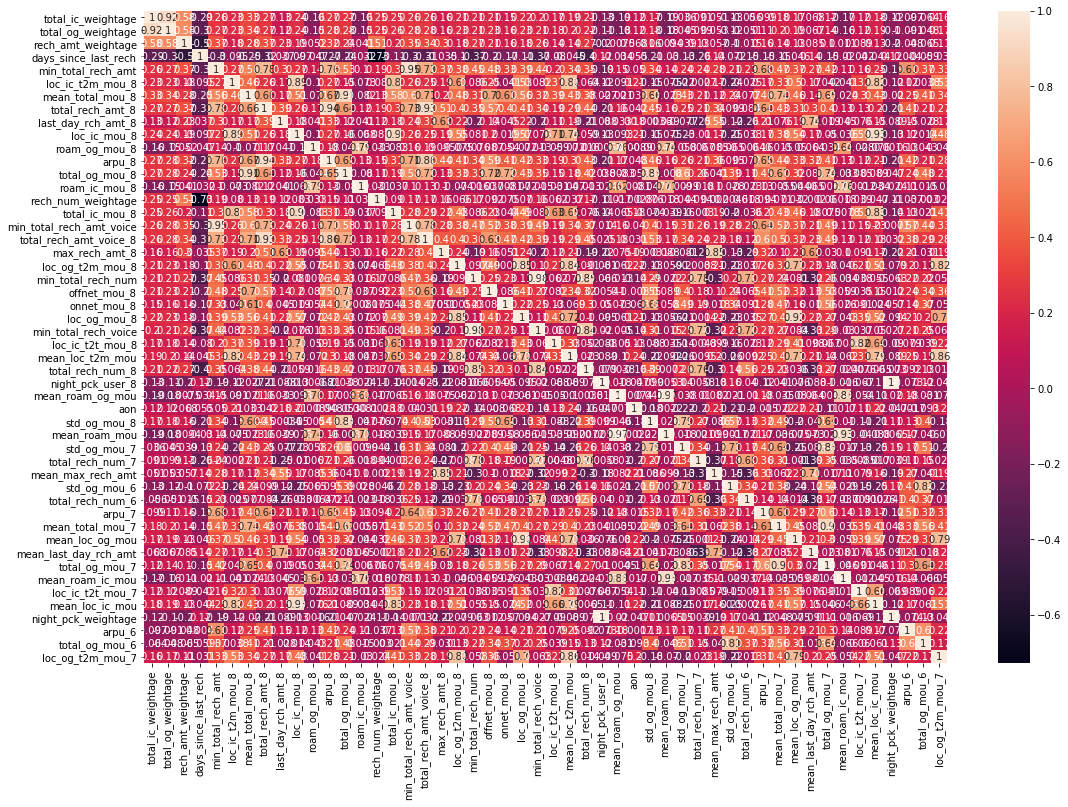

In [113]:
# Heatmap with top 50 features
top_50_features = feature_imp_df[:50]['Feature']
plt.figure(figsize=(18,12))
sns.heatmap(data[top_50_features].corr(), annot=True)

* Now we we'll select only the uncorrelated features from the top 50 features.
* Then we we'll fit the generalized linear model to check the significance of each feature for the model.
* Remove the features with high P-Value to handle the multicollinearity

In [114]:
#selected the uncorrelated features from the top 50 features
cols = ['total_og_weightage','max_rech_amt_8','days_since_last_rech','loc_og_t2m_mou_8','roam_og_mou_8',
        'total_og_mou_8','total_rech_num_8','arpu_8','fb_user_weightage','aon']

X = data[cols]
Y = churn

# fit the data in GLM model
logm = sm.GLM(Y,(sm.add_constant(X)), family = sm.families.Binomial())
modres = logm.fit()
# print the summary results
logm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                29979
Model:                            GLM   Df Residuals:                    29968
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5777.7
Date:                Sat, 20 Feb 2021   Deviance:                       11555.
Time:                        18:39:06   Pearson chi2:                 7.01e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5215      0.130     -3.998      0.000      -0.777      -0.266
total_og_weightage      -0.0206      0.001    -31.588      0.000      -0.022      -0.019
max_rech_amt_8          -0.0015      0.000     -5.155      0.000      -0.002      -0.001
days_since_last_rech     0.0401      0.003     14.423      0.000       0.035       0.045
loc_og_t2m_mou_8        -0.0042      0.000    -12.068      0.000      -0.005      -0.003
roam_og_mou_8            0.0037      0.000     10.406      0.000       0.003       0.004
total_og_mou_8       -1.588e-05   8.16e-05     -0.195      0.846      -0.000       0.000
total_rech_num_8        -0.0159      0.005     -3.145      0.002      -0.026      -0.006
arpu_8                  -0.0007      0.000     -4.263      0.000      -0.001      -0.000
fb_user_weightage        0.0056      0.001     10.466      0.000       0.005       0.007
aon                     -0.0004   3.38e-05    -11.033      0.000      -0.000      -0.000
========================================================================================
"""

total_og_mou_8 seem to have collinearity with the other independent variables. So removing it from the dataset

In [115]:
#selected features with less p-value
cols = ['total_og_weightage','max_rech_amt_8','days_since_last_rech','loc_og_t2m_mou_8','roam_og_mou_8',
        'total_rech_num_8','arpu_8','fb_user_weightage','aon']
data = data[cols]

### Standardize the numerical features

Now, we'll standardize(rescale) the numerical features so as to have mean as 0 and SD as 1

In [116]:
#Standardize the numeric values
data = (( data - data.mean() ) / data.std())

# Handle class imbalance using ADASYN

In [117]:
# Prepare the data
X = data
Y = churn

# Handle class imbalance
adasyn = ADASYN(random_state=RANDOM_STATE)
X, Y = adasyn.fit_sample(X, Y)

print('Class Balance count : ',Counter(Y))


Class Balance count :  Counter({1: 28057, 0: 27390})


# Split into train test 

In [118]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(38812, 9) (38812,)
(16635, 9) (16635,)


In [119]:
print('Y_train :', Counter(Y_train))
print('Y_test :', Counter(Y_test))

Y_train : Counter({1: 19648, 0: 19164})
Y_test : Counter({1: 8409, 0: 8226})


Note that the class is well balanced now. We can now split the train and test dataset.

# Model Building

### ExtraTrees

In [120]:
model = ExtraTreesClassifier(bootstrap=False, class_weight='balanced', criterion='gini', max_depth=60, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, 
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1, oob_score=False, random_state=RANDOM_STATE, verbose=0, warm_start=False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# Model Evaluation

In [121]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.95      0.97      8226
           1       0.95      0.99      0.97      8409

    accuracy                           0.97     16635
   macro avg       0.97      0.97      0.97     16635
weighted avg       0.97      0.97      0.97     16635


TN = 7780, FP = 446, FN = 76, TP = 8333


Accuracy Score :  96.86
ROC AUC score :  96.84
Precision score :  94.92
Recall score :  99.1


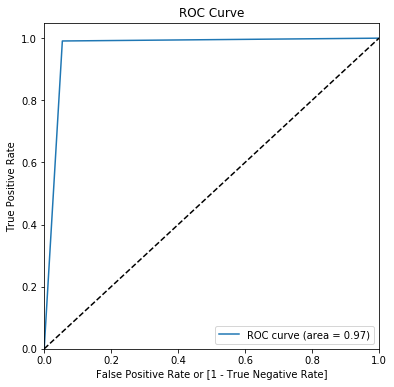

In [123]:
# ROC-AUC curve
plot_roc_curve(Y_test, Y_pred)

We are able to achieve the **Recall Score of 99.1%** with the selected features. Also the above ROC curve seems to be in a good shape. 

# Strategy recommendation to manage customer churn

#### Features contribution plot

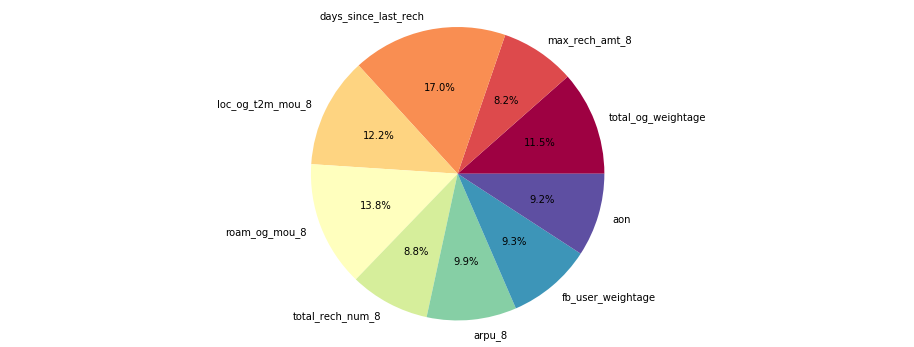

In [124]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 9)]

plt.figure(figsize=(16,6))
plt.pie(model.feature_importances_, labels=data.columns, autopct='%1.1f%%', shadow=False, colors=colors)
plt.axis('equal')
plt.show()

#### Featurewise churn plot

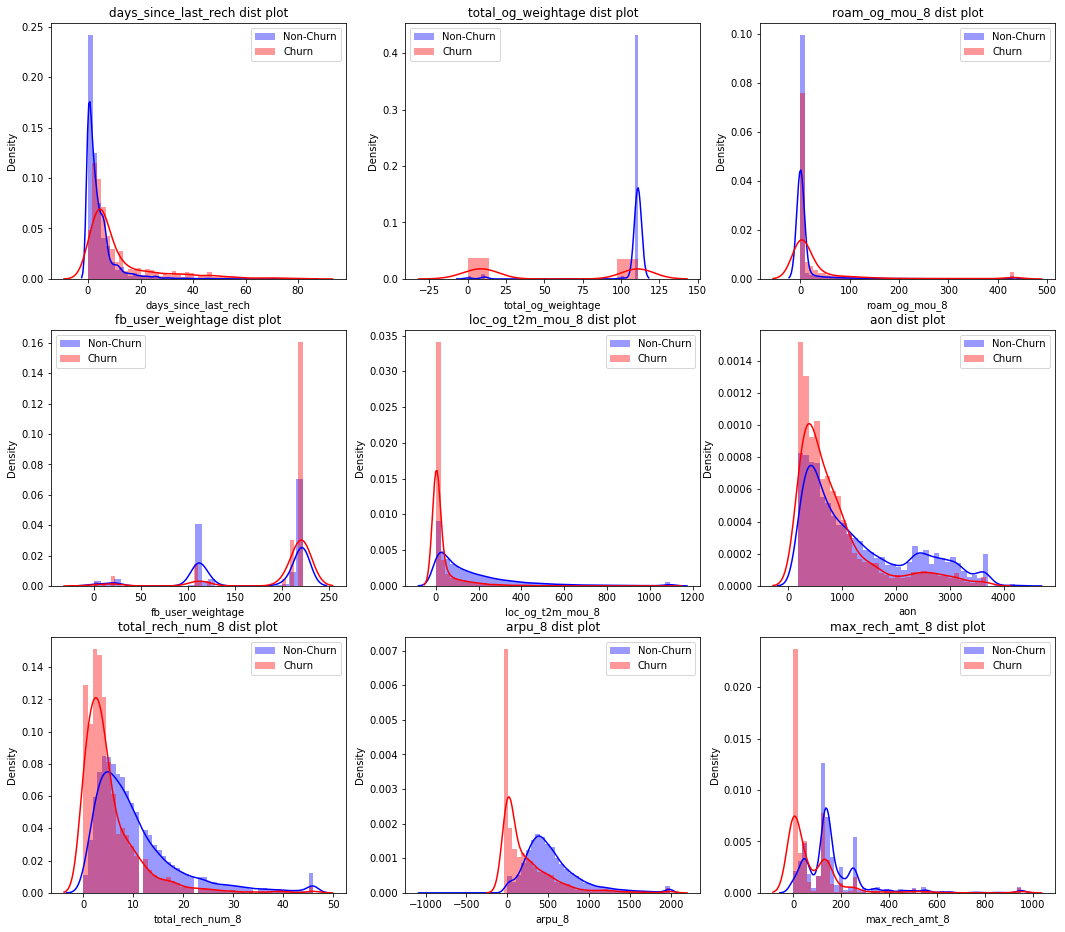

In [125]:
# Data preparation
data = master_df.copy()

#selected final list of features
cols = ['days_since_last_rech','total_og_weightage','roam_og_mou_8','fb_user_weightage','loc_og_t2m_mou_8','aon',
        'total_rech_num_8','arpu_8','max_rech_amt_8']

data = data[cols]
data['churn'] = master_df['churn']

plt.figure(figsize=(18,16))

for i, col in enumerate(cols):

    plt.subplot(3,3,i+1)
    ax = sns.distplot(data.loc[data['churn']==0, [col]], color='b', label='Non-Churn')
    ax = sns.distplot(data.loc[data['churn']==1, [col]], color='r', label='Churn')
    ax.legend()
    plt.xlabel(col)
    plt.title('{0} dist plot'.format(col))

# Conclusion
**The observation on the important predictors of customer churn is as follows,**
##### days_since_last_rech
- Represents the number of days since last recharge. Lower value has got high churn rate.

##### total_og_weightage
- Represents the total outgoing minutes of usage for the last 3 months with the increasing weightage. Lower value comparatively got more churn than the other. 

##### roam_og_mou_8
- Represents the total outgoing minutes of usage on roaming in the recent month. Lower the value higher the churn rate.

##### fb_user_weightage
- Represents the fb user pack usage for the last 3 months with the increasing weightage. Higher the value higher the churn rate.

##### loc_og_t2m_mou_8
- Represents the total outgoing minutes of usage calls to other mobiles in the recent month. Lower value has got high churn rate.

##### aon
- Represents the age on netwok for the last 3 months. Lower value comparatively got more churn than the other.

##### total_rech_num_8
- Represents the total number of times recharged in the recent month. Lower the value higher the churn rate.

##### arpu_8
- Represents the average revenue per user in the recent month. Lower value has got high churn rate. 

##### max_rech_amt_8
- Represents the maximum recharged amount in the recent month. Lower value comparatively got more churn than the other.

## Hence we recommend the Telecom company to consider these driver variables which are strong indicators to manage customer churn.   